In [1]:
import json
import csv
import pandas as pd
import numpy as np
import scipy as sci
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import requests
import tensorflow as tf
from scipy import sparse
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, f1_score
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os

C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Processing

In [2]:
#Open business.json file, create tsv file with business_id, business name, categories, and review count to be used as features 
#and stars as label

outfile = open("business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','categories', 'stars', 'review_count', 'postal code'])
with open('yelp_academic_dataset_business.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'], row['categories'], row['stars'], row['review_count'], row['postal_code']])

outfile.close()

business_df= pd.read_csv('business.tsv', delimiter ="\t")

In [3]:
#Open review.json file, create tsv file with business_id,text to be used as features 
#and stars as label

outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('yelp_academic_dataset_review.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()

review_df= pd.read_csv('review_stars.tsv', delimiter ="\t")

In [4]:
# Group all reviews by business_id
review_agg_df = review_df.groupby('business_id')['text'].sum()
review_df_ready_for_sklearn = pd.DataFrame({'business_id': review_agg_df.index, 'all_reviews': review_agg_df.values})

In [5]:
#Merge the resulting review aggregate dataframe with business dataframe
merge_df = pd.merge(business_df, review_df_ready_for_sklearn, on='business_id')

In [6]:
#Normalization of review count field so it becomes comparable and remove bias

from scipy.stats import zscore

merge_df.insert(3,'normalized_count',((merge_df['review_count'] - merge_df['review_count'].min()) / (merge_df['review_count'].max() - merge_df['review_count'].min())).astype(float))
merge_df['review_count'] = zscore(merge_df['review_count'])


In [7]:
# removing NaN categories

merge_df = merge_df[merge_df['categories'].notnull()]
merge_df = merge_df[0:10000]

In [8]:
# Extracting categories

from sklearn.preprocessing import MultiLabelBinarizer
encoded_categories = MultiLabelBinarizer()
category_matrix = encoded_categories.fit_transform(merge_df['categories'].str.split(','))

In [9]:
#TF-IDF calculation

tfidf = sk_text.TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,3))

In [10]:
# Fit the reviews column with TFIDFvectorizer
matrix = tfidf.fit_transform(merge_df['all_reviews'])
matrix = matrix.toarray()

In [11]:
# We are adding the normalized count to the original matrix with TFIDFvectorizer
x_matrix_minmax = np.column_stack((matrix, merge_df['normalized_count']))

# Zscore
x_matrix_zscore = np.column_stack((matrix, merge_df['review_count']))

In [12]:
#train test data for linear regression

x_train, x_test, y_train, y_test = train_test_split(x_matrix_minmax, merge_df['stars'] , test_size=0.2, random_state=42)

# Training and prediction using Regression

In [178]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [13]:
# linear regression

lin_reg_model = LinearRegression()

lin_reg_model.fit(x_train, y_train)

y_pred_linear = lin_reg_model.predict(x_test)

In [14]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test.index[i]
    print("business id - %s actual stars  - %f predicted - %f" 
          %(merge_df['business_id'][idx], y_test[idx], y_pred_linear[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars  - 4.000000 predicted - 3.643041
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars  - 4.000000 predicted - 3.900257
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars  - 4.000000 predicted - 4.197429
business id - jrhc4s5XMR8S8kpGdU08og actual stars  - 4.500000 predicted - 4.797609
business id - e7207sqC-pSn6GIf31ikhQ actual stars  - 4.000000 predicted - 3.765016
business id - CF9TxeEdP5QxihYFAl4sUg actual stars  - 4.000000 predicted - 4.057981
business id - zZPCAFK85NtitSNVP_wfYg actual stars  - 3.500000 predicted - 3.503671
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars  - 5.000000 predicted - 4.855848
business id - TTrYd662CZFRPaiwl-sUqA actual stars  - 2.000000 predicted - 1.747432
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars  - 2.500000 predicted - 2.484346


In [15]:
# RMS value

score_lin_classic = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print("Root Mean Squared Error: %.2f" % score_lin_classic)
print('R2 score: %.2f' % r2_score(y_test, y_pred_linear))

Root Mean Squared Error: 0.56
R2 score: 0.70


In [16]:
# label encoding data for logistic regression

label_encoder = preprocessing.LabelEncoder()

merge_df['encoded_stars'] = label_encoder.fit_transform(merge_df['stars'])

In [17]:
# train test data afor other models

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, merge_df['encoded_stars'] , test_size=0.2, random_state=42)

In [18]:
# logistic Regression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_train_lr, y_train_lr)

y_pred_logistic = Log_reg_model.predict(x_test_lr)


In [19]:
# RMs for logistic

score_log_classic = np.sqrt(mean_squared_error(y_test_lr, y_pred_logistic))
print("Root Mean Squared Error: %.2f" % score_log_classic)
print('R2 score: %.2f' % r2_score(y_test_lr, y_pred_logistic))


Root Mean Squared Error: 1.38
R2 score: 0.54


# Tensorflow Model for Regression

## Training without early stopping and Model Checkpoint and RELU 

In [20]:
#Tensor flow works well with 32 bit
y_stars_regression = merge_df['stars'].values.astype(np.float32)

In [21]:
#train test data
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_matrix_minmax, y_stars_regression , test_size=0.2)


In [22]:
# Tensorflow model for Regression with RELU

model_reg_relu = Sequential()

model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(1)) # Output

In [23]:
#Model training with Optimizer = adam

model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
model_reg_relu.fit(x_train_reg,y_train_reg,verbose=2,epochs=100) 


Epoch 1/100
 - 1s - loss: 2.0906
Epoch 2/100
 - 0s - loss: 0.3293
Epoch 3/100
 - 0s - loss: 0.2660
Epoch 4/100
 - 0s - loss: 0.2482
Epoch 5/100
 - 0s - loss: 0.2355
Epoch 6/100
 - 0s - loss: 0.2105
Epoch 7/100
 - 0s - loss: 0.1797
Epoch 8/100
 - 1s - loss: 0.1524
Epoch 9/100
 - 0s - loss: 0.1240
Epoch 10/100
 - 0s - loss: 0.1018
Epoch 11/100
 - 0s - loss: 0.0840
Epoch 12/100
 - 0s - loss: 0.0712
Epoch 13/100
 - 0s - loss: 0.0596
Epoch 14/100
 - 0s - loss: 0.0513
Epoch 15/100
 - 0s - loss: 0.0440
Epoch 16/100
 - 0s - loss: 0.0399
Epoch 17/100
 - 0s - loss: 0.0342
Epoch 18/100
 - 0s - loss: 0.0301
Epoch 19/100
 - 0s - loss: 0.0282
Epoch 20/100
 - 0s - loss: 0.0261
Epoch 21/100
 - 0s - loss: 0.0242
Epoch 22/100
 - 0s - loss: 0.0228
Epoch 23/100
 - 0s - loss: 0.0203
Epoch 24/100
 - 1s - loss: 0.0193
Epoch 25/100
 - 1s - loss: 0.0191
Epoch 26/100
 - 0s - loss: 0.0175
Epoch 27/100
 - 0s - loss: 0.0167
Epoch 28/100
 - 0s - loss: 0.0156
Epoch 29/100
 - 0s - loss: 0.0165
Epoch 30/100
 - 0s - lo

In [24]:
# Predict stars
pred_reg_simple = model_reg_relu.predict(x_test_reg)
print("Shape: {}".format(pred_reg_simple.shape))


Shape: (2000, 1)


In [25]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_simple[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [2.1067386]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.568747]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.682547]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.0523095]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.590995]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.7832203]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.6607018]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [5.4459567]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.0730624]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.7443786]


In [26]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_relu = np.sqrt(mean_squared_error(y_test_reg,pred_reg_simple))
print("Final score (RMSE): {}".format(score_reg_relu))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_simple))

Final score (RMSE): 0.5928863883018494
R2 score: 0.64


## Training with early stopping and Model Checkpoint ReLU 

In [27]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu.hdf5", verbose=1, save_best_only=True)

In [28]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 2.4768 - val_loss: 0.4563

Epoch 00001: val_loss improved from inf to 0.45625, saving model to ./best_weights_relu.hdf5
Epoch 2/100
 - 0s - loss: 0.3558 - val_loss: 0.3284

Epoch 00002: val_loss improved from 0.45625 to 0.32835, saving model to ./best_weights_relu.hdf5
Epoch 3/100
 - 0s - loss: 0.2714 - val_loss: 0.2928

Epoch 00003: val_loss improved from 0.32835 to 0.29276, saving model to ./best_weights_relu.hdf5
Epoch 4/100
 - 0s - loss: 0.2460 - val_loss: 0.2977

Epoch 00004: val_loss did not improve from 0.29276
Epoch 5/100
 - 0s - loss: 0.2301 - val_loss: 0.2890

Epoch 00005: val_loss improved from 0.29276 to 0.28904, saving model to ./best_weights_relu.hdf5
Epoch 6/100
 - 0s - loss: 0.2135 - val_loss: 0.2829

Epoch 00006: val_loss improved from 0.28904 to 0.28294, saving model to ./best_weights_relu.hdf5
Epoch 7/100
 - 0s - loss: 0.1873 - val_loss: 0.2782

Epoch 00007: val_loss improved from 0.28294 to 


Epoch 00008: val_loss did not improve from 0.27118
Epoch 9/100
 - 1s - loss: 0.1322 - val_loss: 0.2820

Epoch 00009: val_loss did not improve from 0.27118
Epoch 10/100
 - 1s - loss: 0.1091 - val_loss: 0.2993

Epoch 00010: val_loss did not improve from 0.27118
Epoch 11/100
 - 0s - loss: 0.0900 - val_loss: 0.2922

Epoch 00011: val_loss did not improve from 0.27118
Epoch 12/100
 - 0s - loss: 0.0741 - val_loss: 0.2974

Epoch 00012: val_loss did not improve from 0.27118
Epoch 13/100
 - 1s - loss: 0.0615 - val_loss: 0.3067

Epoch 00013: val_loss did not improve from 0.27118
Epoch 00013: early stopping
6
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 1.9543 - val_loss: 0.3867

Epoch 00001: val_loss did not improve from 0.27118
Epoch 2/100
 - 0s - loss: 0.3119 - val_loss: 0.3037

Epoch 00002: val_loss did not improve from 0.27118
Epoch 3/100
 - 0s - loss: 0.2562 - val_loss: 0.2886

Epoch 00003: val_loss did not improve from 0.27118
Epoch 4/100
 - 1s - loss: 0.2385 -

In [29]:
# Predict stars
pred_reg_stopping = model_reg_relu.predict(x_test_reg)
print("Shape: {}".format(pred_reg_stopping.shape))

Shape: (2000, 1)


In [30]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.1589713]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.5486484]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.605691]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.002837]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.1924605]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.8385916]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.8331656]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [3.999655]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.003024]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.869155]


In [31]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_relu_stopping = np.sqrt(mean_squared_error(y_test_reg,pred_reg_stopping))
print("Final score (RMSE): {}".format(score_reg_relu_stopping))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_stopping))

Final score (RMSE): 0.5207536816596985
R2 score: 0.72


# Experimenting with different optimizers for ReLU

## SGD 

In [32]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_sgd.hdf5", verbose=1, save_best_only=True)

In [33]:
#Model training with Stochastic gradient descent optimizer(SGD).
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_sgd.hdf5')


0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 1.2486 - val_loss: 0.6791

Epoch 00001: val_loss improved from inf to 0.67909, saving model to ./best_weights_relu_sgd.hdf5
Epoch 2/100
 - 0s - loss: 0.5485 - val_loss: 0.3984

Epoch 00002: val_loss improved from 0.67909 to 0.39845, saving model to ./best_weights_relu_sgd.hdf5
Epoch 3/100
 - 0s - loss: 0.3708 - val_loss: 0.3403

Epoch 00003: val_loss improved from 0.39845 to 0.34029, saving model to ./best_weights_relu_sgd.hdf5
Epoch 4/100
 - 0s - loss: 0.3320 - val_loss: 0.3207

Epoch 00004: val_loss improved from 0.34029 to 0.32073, saving model to ./best_weights_relu_sgd.hdf5
Epoch 5/100
 - 0s - loss: 0.3134 - val_loss: 0.3099

Epoch 00005: val_loss improved from 0.32073 to 0.30990, saving model to ./best_weights_relu_sgd.hdf5
Epoch 6/100
 - 0s - loss: 0.3002 - val_loss: 0.3073

Epoch 00006: val_loss improved from 0.30990 to 0.30729, saving model to ./best_weights_relu_sgd.hdf5
Epoch 7/100
 - 0s - loss: 0.29


Epoch 00035: val_loss improved from 0.25926 to 0.25778, saving model to ./best_weights_relu_sgd.hdf5
Epoch 36/100
 - 1s - loss: 0.1981 - val_loss: 0.2584

Epoch 00036: val_loss did not improve from 0.25778
Epoch 37/100
 - 0s - loss: 0.1952 - val_loss: 0.2560

Epoch 00037: val_loss improved from 0.25778 to 0.25605, saving model to ./best_weights_relu_sgd.hdf5
Epoch 38/100
 - 0s - loss: 0.1937 - val_loss: 0.2657

Epoch 00038: val_loss did not improve from 0.25605
Epoch 39/100
 - 0s - loss: 0.1922 - val_loss: 0.2609

Epoch 00039: val_loss did not improve from 0.25605
Epoch 40/100
 - 0s - loss: 0.1906 - val_loss: 0.2587

Epoch 00040: val_loss did not improve from 0.25605
Epoch 41/100
 - 0s - loss: 0.1883 - val_loss: 0.2543

Epoch 00041: val_loss improved from 0.25605 to 0.25430, saving model to ./best_weights_relu_sgd.hdf5
Epoch 42/100
 - 0s - loss: 0.1871 - val_loss: 0.2548

Epoch 00042: val_loss did not improve from 0.25430
Epoch 43/100
 - 0s - loss: 0.1852 - val_loss: 0.2555

Epoch 000


Epoch 00018: val_loss did not improve from 0.25430
Epoch 19/100
 - 0s - loss: 0.2383 - val_loss: 0.2734

Epoch 00019: val_loss did not improve from 0.25430
Epoch 20/100
 - 0s - loss: 0.2350 - val_loss: 0.2750

Epoch 00020: val_loss did not improve from 0.25430
Epoch 21/100
 - 0s - loss: 0.2314 - val_loss: 0.2708

Epoch 00021: val_loss did not improve from 0.25430
Epoch 22/100
 - 0s - loss: 0.2299 - val_loss: 0.2719

Epoch 00022: val_loss did not improve from 0.25430
Epoch 23/100
 - 0s - loss: 0.2260 - val_loss: 0.2679

Epoch 00023: val_loss did not improve from 0.25430
Epoch 24/100
 - 0s - loss: 0.2241 - val_loss: 0.2754

Epoch 00024: val_loss did not improve from 0.25430
Epoch 25/100
 - 0s - loss: 0.2216 - val_loss: 0.2662

Epoch 00025: val_loss did not improve from 0.25430
Epoch 26/100
 - 0s - loss: 0.2189 - val_loss: 0.2821

Epoch 00026: val_loss did not improve from 0.25430
Epoch 27/100
 - 0s - loss: 0.2172 - val_loss: 0.2668

Epoch 00027: val_loss did not improve from 0.25430
Epo

 - 0s - loss: 0.2407 - val_loss: 0.2786

Epoch 00016: val_loss did not improve from 0.25395
Epoch 17/100
 - 0s - loss: 0.2380 - val_loss: 0.2744

Epoch 00017: val_loss did not improve from 0.25395
Epoch 18/100
 - 0s - loss: 0.2335 - val_loss: 0.2712

Epoch 00018: val_loss did not improve from 0.25395
Epoch 19/100
 - 0s - loss: 0.2325 - val_loss: 0.2741

Epoch 00019: val_loss did not improve from 0.25395
Epoch 20/100
 - 0s - loss: 0.2296 - val_loss: 0.2714

Epoch 00020: val_loss did not improve from 0.25395
Epoch 21/100
 - 1s - loss: 0.2270 - val_loss: 0.2678

Epoch 00021: val_loss did not improve from 0.25395
Epoch 22/100
 - 1s - loss: 0.2233 - val_loss: 0.2676

Epoch 00022: val_loss did not improve from 0.25395
Epoch 23/100
 - 1s - loss: 0.2214 - val_loss: 0.2793

Epoch 00023: val_loss did not improve from 0.25395
Epoch 24/100
 - 0s - loss: 0.2198 - val_loss: 0.2805

Epoch 00024: val_loss did not improve from 0.25395
Epoch 25/100
 - 0s - loss: 0.2155 - val_loss: 0.2640

Epoch 00025: v

 - 0s - loss: 0.2397 - val_loss: 0.2766

Epoch 00020: val_loss did not improve from 0.24956
Epoch 21/100
 - 0s - loss: 0.2362 - val_loss: 0.2763

Epoch 00021: val_loss did not improve from 0.24956
Epoch 22/100
 - 0s - loss: 0.2330 - val_loss: 0.2808

Epoch 00022: val_loss did not improve from 0.24956
Epoch 23/100
 - 0s - loss: 0.2307 - val_loss: 0.2773

Epoch 00023: val_loss did not improve from 0.24956
Epoch 24/100
 - 1s - loss: 0.2286 - val_loss: 0.2774

Epoch 00024: val_loss did not improve from 0.24956
Epoch 25/100
 - 1s - loss: 0.2263 - val_loss: 0.2821

Epoch 00025: val_loss did not improve from 0.24956
Epoch 00025: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 1.4480 - val_loss: 0.7691

Epoch 00001: val_loss did not improve from 0.24956
Epoch 2/100
 - 0s - loss: 0.6533 - val_loss: 0.4780

Epoch 00002: val_loss did not improve from 0.24956
Epoch 3/100
 - 0s - loss: 0.4074 - val_loss: 0.3569

Epoch 00003: val_loss did not improve from 0

In [34]:
# Predict stars
pred_reg_sgd = model_reg_relu.predict(x_test_reg)

In [35]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_sgd[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.2288952]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.950254]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.646233]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.0801954]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.172542]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.6103296]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.7259464]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [3.8494282]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [3.9009638]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.7853088]


In [36]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_sgd = np.sqrt(mean_squared_error(y_test_reg,pred_reg_sgd))
print("Final score (RMSE): {}".format(score_relu_sgd))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_sgd))

Final score (RMSE): 0.4995602071285248
R2 score: 0.74


## RMSProp 

In [37]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_rmsprop.hdf5", verbose=1, save_best_only=True)

In [38]:
#Model training with RMSProp optimizer.

for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_rmsprop.hdf5')


0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 1.3151 - val_loss: 0.3219

Epoch 00001: val_loss improved from inf to 0.32189, saving model to ./best_weights_relu_rmsprop.hdf5
Epoch 2/100
 - 1s - loss: 0.2888 - val_loss: 0.3018

Epoch 00002: val_loss improved from 0.32189 to 0.30181, saving model to ./best_weights_relu_rmsprop.hdf5
Epoch 3/100
 - 1s - loss: 0.2557 - val_loss: 0.3133

Epoch 00003: val_loss did not improve from 0.30181
Epoch 4/100
 - 1s - loss: 0.2324 - val_loss: 0.2815

Epoch 00004: val_loss improved from 0.30181 to 0.28149, saving model to ./best_weights_relu_rmsprop.hdf5
Epoch 5/100
 - 1s - loss: 0.2083 - val_loss: 0.2724

Epoch 00005: val_loss improved from 0.28149 to 0.27244, saving model to ./best_weights_relu_rmsprop.hdf5
Epoch 6/100
 - 1s - loss: 0.1821 - val_loss: 0.2796

Epoch 00006: val_loss did not improve from 0.27244
Epoch 7/100
 - 1s - loss: 0.1587 - val_loss: 0.2676

Epoch 00007: val_loss improved from 0.27244 to 0.26760, savin


Epoch 00011: val_loss did not improve from 0.26444
Epoch 12/100
 - 1s - loss: 0.0858 - val_loss: 0.2983

Epoch 00012: val_loss did not improve from 0.26444
Epoch 13/100
 - 1s - loss: 0.0775 - val_loss: 0.2990

Epoch 00013: val_loss did not improve from 0.26444
Epoch 00013: early stopping
6
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 1.4877 - val_loss: 0.3448

Epoch 00001: val_loss did not improve from 0.26444
Epoch 2/100
 - 1s - loss: 0.2927 - val_loss: 0.2918

Epoch 00002: val_loss did not improve from 0.26444
Epoch 3/100
 - 1s - loss: 0.2590 - val_loss: 0.2944

Epoch 00003: val_loss did not improve from 0.26444
Epoch 4/100
 - 1s - loss: 0.2422 - val_loss: 0.2858

Epoch 00004: val_loss did not improve from 0.26444
Epoch 5/100
 - 1s - loss: 0.2238 - val_loss: 0.2792

Epoch 00005: val_loss did not improve from 0.26444
Epoch 6/100
 - 1s - loss: 0.2021 - val_loss: 0.2913

Epoch 00006: val_loss did not improve from 0.26444
Epoch 7/100
 - 1s - loss: 0.1771 - v

In [39]:
# Predict stars
pred_reg_rmsprop = model_reg_relu.predict(x_test_reg)

In [40]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_rmsprop[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.1625855]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.750733]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.80315]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.145072]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.4359465]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.924612]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.75189]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.1631236]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [3.9477315]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.8618743]


In [41]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_rmsprop = np.sqrt(mean_squared_error(y_test_reg,pred_reg_rmsprop))
print("Final score (RMSE): {}".format(score_relu_rmsprop))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_rmsprop))

Final score (RMSE): 0.5123857855796814
R2 score: 0.73


## Adagrad 

In [42]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_adagrad.hdf5", verbose=1, save_best_only=True)

In [43]:
#Model training with Adagrad.

for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adagrad')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_adagrad.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 2s - loss: 0.8264 - val_loss: 0.3450

Epoch 00001: val_loss improved from inf to 0.34496, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 2/100
 - 1s - loss: 0.2954 - val_loss: 0.3034

Epoch 00002: val_loss improved from 0.34496 to 0.30340, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 3/100
 - 1s - loss: 0.2547 - val_loss: 0.2955

Epoch 00003: val_loss improved from 0.30340 to 0.29550, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 4/100
 - 1s - loss: 0.2340 - val_loss: 0.2876

Epoch 00004: val_loss improved from 0.29550 to 0.28759, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 5/100
 - 1s - loss: 0.2202 - val_loss: 0.2863

Epoch 00005: val_loss improved from 0.28759 to 0.28633, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 6/100
 - 1s - loss: 0.2056 - val_loss: 0.2847

Epoch 00006: val_loss improved from 0.28633 to 0.28471, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 

 - 1s - loss: 0.2571 - val_loss: 0.2931

Epoch 00003: val_loss did not improve from 0.26563
Epoch 4/100
 - 1s - loss: 0.2346 - val_loss: 0.2857

Epoch 00004: val_loss did not improve from 0.26563
Epoch 5/100
 - 1s - loss: 0.2178 - val_loss: 0.2858

Epoch 00005: val_loss did not improve from 0.26563
Epoch 6/100
 - 1s - loss: 0.2023 - val_loss: 0.2783

Epoch 00006: val_loss did not improve from 0.26563
Epoch 7/100
 - 1s - loss: 0.1867 - val_loss: 0.2732

Epoch 00007: val_loss did not improve from 0.26563
Epoch 8/100
 - 1s - loss: 0.1717 - val_loss: 0.2685

Epoch 00008: val_loss did not improve from 0.26563
Epoch 9/100
 - 1s - loss: 0.1577 - val_loss: 0.2674

Epoch 00009: val_loss did not improve from 0.26563
Epoch 10/100
 - 1s - loss: 0.1445 - val_loss: 0.2665

Epoch 00010: val_loss did not improve from 0.26563
Epoch 11/100
 - 1s - loss: 0.1318 - val_loss: 0.2697

Epoch 00011: val_loss did not improve from 0.26563
Epoch 12/100
 - 1s - loss: 0.1211 - val_loss: 0.2646

Epoch 00012: val_los

 - 1s - loss: 0.2032 - val_loss: 0.2790

Epoch 00008: val_loss did not improve from 0.26455
Epoch 9/100
 - 1s - loss: 0.1915 - val_loss: 0.2761

Epoch 00009: val_loss did not improve from 0.26455
Epoch 10/100
 - 1s - loss: 0.1808 - val_loss: 0.2733

Epoch 00010: val_loss did not improve from 0.26455
Epoch 11/100
 - 1s - loss: 0.1697 - val_loss: 0.2728

Epoch 00011: val_loss did not improve from 0.26455
Epoch 12/100
 - 1s - loss: 0.1589 - val_loss: 0.2734

Epoch 00012: val_loss did not improve from 0.26455
Epoch 13/100
 - 1s - loss: 0.1482 - val_loss: 0.2723

Epoch 00013: val_loss did not improve from 0.26455
Epoch 14/100
 - 1s - loss: 0.1379 - val_loss: 0.2737

Epoch 00014: val_loss did not improve from 0.26455
Epoch 15/100
 - 1s - loss: 0.1280 - val_loss: 0.2752

Epoch 00015: val_loss did not improve from 0.26455
Epoch 00015: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 0.7645 - val_loss: 0.3499

Epoch 00001: val_loss did not improve from 

In [44]:
# Predict stars
pred_reg_adagrad = model_reg_relu.predict(x_test_reg)

In [45]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_adagrad[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.1785238]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.7580104]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.5060987]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [3.9313974]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [3.981377]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.911565]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.737559]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.0704503]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.077872]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.7188265]


In [46]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_adagrad = np.sqrt(mean_squared_error(y_test_reg,pred_reg_adagrad))
print("Final score (RMSE): {}".format(score_relu_adagrad))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_adagrad))

Final score (RMSE): 0.5143455862998962
R2 score: 0.73


## Adadelta 

In [47]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_adadelta.hdf5", verbose=1, save_best_only=True)

In [48]:
#Model training with ADadelta.

for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adadelta')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_adadelta.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 2s - loss: 1.0485 - val_loss: 0.3101

Epoch 00001: val_loss improved from inf to 0.31010, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 2/100
 - 1s - loss: 0.2797 - val_loss: 0.3100

Epoch 00002: val_loss improved from 0.31010 to 0.30998, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 3/100
 - 1s - loss: 0.2562 - val_loss: 0.2936

Epoch 00003: val_loss improved from 0.30998 to 0.29357, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 4/100
 - 1s - loss: 0.2396 - val_loss: 0.2784

Epoch 00004: val_loss improved from 0.29357 to 0.27844, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 5/100
 - 1s - loss: 0.2150 - val_loss: 0.2892

Epoch 00005: val_loss did not improve from 0.27844
Epoch 6/100
 - 2s - loss: 0.1954 - val_loss: 0.2971

Epoch 00006: val_loss did not improve from 0.27844
Epoch 7/100
 - 3s - loss: 0.1708 - val_loss: 0.2988

Epoch 00007: val_loss did not improve from 0.27844
Epoch 


Epoch 00006: val_loss did not improve from 0.26085
Epoch 7/100
 - 1s - loss: 0.1647 - val_loss: 0.2639

Epoch 00007: val_loss did not improve from 0.26085
Epoch 8/100
 - 1s - loss: 0.1422 - val_loss: 0.2649

Epoch 00008: val_loss did not improve from 0.26085
Epoch 9/100
 - 1s - loss: 0.1256 - val_loss: 0.3029

Epoch 00009: val_loss did not improve from 0.26085
Epoch 10/100
 - 1s - loss: 0.1106 - val_loss: 0.2863

Epoch 00010: val_loss did not improve from 0.26085
Epoch 11/100
 - 1s - loss: 0.0986 - val_loss: 0.2797

Epoch 00011: val_loss did not improve from 0.26085
Epoch 12/100
 - 1s - loss: 0.0867 - val_loss: 0.2772

Epoch 00012: val_loss did not improve from 0.26085
Epoch 00012: early stopping
6
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 2s - loss: 1.1219 - val_loss: 0.3077

Epoch 00001: val_loss did not improve from 0.26085
Epoch 2/100
 - 1s - loss: 0.2783 - val_loss: 0.2823

Epoch 00002: val_loss did not improve from 0.26085
Epoch 3/100
 - 1s - loss: 0.2539 - 

In [49]:
# Predict stars
pred_reg_adadelta = model_reg_relu.predict(x_test_reg)

In [50]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_adadelta[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.1392732]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.8013694]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.764119]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [3.9387994]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.159484]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.923687]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.6242514]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.1230307]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.273744]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [3.0436504]


In [51]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_adadelta = np.sqrt(mean_squared_error(y_test_reg,pred_reg_adadelta))
print("Final score (RMSE): {}".format(score_relu_adadelta))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_adadelta))

Final score (RMSE): 0.5054019093513489
R2 score: 0.74


## Adamax 

In [52]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_adamax.hdf5", verbose=1, save_best_only=True)

In [53]:
#Model training with Adamax.

for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adamax')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_adamax.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 2s - loss: 2.2227 - val_loss: 0.5059

Epoch 00001: val_loss improved from inf to 0.50589, saving model to ./best_weights_relu_adamax.hdf5
Epoch 2/100
 - 1s - loss: 0.3817 - val_loss: 0.3265

Epoch 00002: val_loss improved from 0.50589 to 0.32650, saving model to ./best_weights_relu_adamax.hdf5
Epoch 3/100
 - 1s - loss: 0.2885 - val_loss: 0.3011

Epoch 00003: val_loss improved from 0.32650 to 0.30106, saving model to ./best_weights_relu_adamax.hdf5
Epoch 4/100
 - 1s - loss: 0.2597 - val_loss: 0.2866

Epoch 00004: val_loss improved from 0.30106 to 0.28655, saving model to ./best_weights_relu_adamax.hdf5
Epoch 5/100
 - 1s - loss: 0.2444 - val_loss: 0.2802

Epoch 00005: val_loss improved from 0.28655 to 0.28022, saving model to ./best_weights_relu_adamax.hdf5
Epoch 6/100
 - 1s - loss: 0.2359 - val_loss: 0.2776

Epoch 00006: val_loss improved from 0.28022 to 0.27765, saving model to ./best_weights_relu_adamax.hdf5
Epoch 7/100


 - 2s - loss: 1.9261 - val_loss: 0.4592

Epoch 00001: val_loss did not improve from 0.27765
Epoch 2/100
 - 1s - loss: 0.3637 - val_loss: 0.3220

Epoch 00002: val_loss did not improve from 0.27765
Epoch 3/100
 - 1s - loss: 0.2841 - val_loss: 0.2907

Epoch 00003: val_loss did not improve from 0.27765
Epoch 4/100
 - 1s - loss: 0.2577 - val_loss: 0.2857

Epoch 00004: val_loss did not improve from 0.27765
Epoch 5/100
 - 1s - loss: 0.2443 - val_loss: 0.2916

Epoch 00005: val_loss did not improve from 0.27765
Epoch 6/100
 - 1s - loss: 0.2369 - val_loss: 0.2828

Epoch 00006: val_loss did not improve from 0.27765
Epoch 7/100
 - 1s - loss: 0.2281 - val_loss: 0.2842

Epoch 00007: val_loss did not improve from 0.27765
Epoch 8/100
 - 1s - loss: 0.2203 - val_loss: 0.2820

Epoch 00008: val_loss did not improve from 0.27765
Epoch 9/100
 - 1s - loss: 0.2121 - val_loss: 0.2870

Epoch 00009: val_loss did not improve from 0.27765
Epoch 10/100
 - 1s - loss: 0.1999 - val_loss: 0.2753

Epoch 00010: val_loss 

In [54]:
# Predict stars
pred_reg_adamax = model_reg_relu.predict(x_test_reg)

In [55]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_adamax[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.0921342]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.9031482]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.745195]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.0004554]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [3.9323356]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.975093]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.5537486]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.1400733]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [3.8123753]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.7884164]


In [56]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_adamax = np.sqrt(mean_squared_error(y_test_reg,pred_reg_adamax))
print("Final score (RMSE): {}".format(score_relu_adamax))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_adamax))

Final score (RMSE): 0.5081221461296082
R2 score: 0.74


## Nadam 

In [57]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_nadam.hdf5", verbose=1, save_best_only=True)

In [58]:
#Model training with Nadam.

for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='nadam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_nadam.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 1.2243 - val_loss: 0.3243

Epoch 00001: val_loss improved from inf to 0.32429, saving model to ./best_weights_relu_nadam.hdf5
Epoch 2/100
 - 1s - loss: 0.2854 - val_loss: 0.3206

Epoch 00002: val_loss improved from 0.32429 to 0.32060, saving model to ./best_weights_relu_nadam.hdf5
Epoch 3/100
 - 1s - loss: 0.2551 - val_loss: 0.3275

Epoch 00003: val_loss did not improve from 0.32060
Epoch 4/100
 - 1s - loss: 0.2292 - val_loss: 0.2818

Epoch 00004: val_loss improved from 0.32060 to 0.28183, saving model to ./best_weights_relu_nadam.hdf5
Epoch 5/100
 - 1s - loss: 0.1995 - val_loss: 0.2752

Epoch 00005: val_loss improved from 0.28183 to 0.27515, saving model to ./best_weights_relu_nadam.hdf5
Epoch 6/100
 - 1s - loss: 0.1695 - val_loss: 0.2888

Epoch 00006: val_loss did not improve from 0.27515
Epoch 7/100
 - 1s - loss: 0.1373 - val_loss: 0.3249

Epoch 00007: val_loss did not improve from 0.27515
Epoch 8/100
 - 1s 


Epoch 00009: val_loss did not improve from 0.27300
Epoch 10/100
 - 1s - loss: 0.0682 - val_loss: 0.2980

Epoch 00010: val_loss did not improve from 0.27300
Epoch 11/100
 - 1s - loss: 0.0584 - val_loss: 0.3257

Epoch 00011: val_loss did not improve from 0.27300
Epoch 00011: early stopping
7
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 1.1427 - val_loss: 0.3421

Epoch 00001: val_loss did not improve from 0.27300
Epoch 2/100
 - 1s - loss: 0.2834 - val_loss: 0.3069

Epoch 00002: val_loss did not improve from 0.27300
Epoch 3/100
 - 1s - loss: 0.2523 - val_loss: 0.2866

Epoch 00003: val_loss did not improve from 0.27300
Epoch 4/100
 - 1s - loss: 0.2105 - val_loss: 0.2889

Epoch 00004: val_loss did not improve from 0.27300
Epoch 5/100
 - 1s - loss: 0.1714 - val_loss: 0.2860

Epoch 00005: val_loss did not improve from 0.27300
Epoch 6/100
 - 1s - loss: 0.1407 - val_loss: 0.2854

Epoch 00006: val_loss did not improve from 0.27300
Epoch 7/100
 - 1s - loss: 0.1105 - v

In [59]:
# Predict stars
pred_reg_nadam = model_reg_relu.predict(x_test_reg)

In [60]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_nadam[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.2940738]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.6654196]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.591123]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.0020547]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.586219]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.7807727]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.8276873]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [3.7874167]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [3.8861163]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.7481275]


In [61]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_nadam = np.sqrt(mean_squared_error(y_test_reg,pred_reg_nadam))
print("Final score (RMSE): {}".format(score_relu_nadam))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_nadam))

Final score (RMSE): 0.5224981307983398
R2 score: 0.72


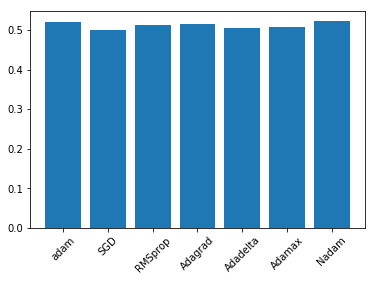

In [62]:
#Plot to show the best optimizer

score_list_reg_opt=[score_reg_relu_stopping,score_relu_sgd,score_relu_rmsprop, score_relu_adagrad,score_relu_adadelta,score_relu_adamax,score_relu_nadam]
names =['adam','SGD','RMSprop','Adagrad', 'Adadelta','Adamax','Nadam']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg_opt)), score_list_reg_opt)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# Experiments with hidden layer 

## 2 hidden Layers with adam optimizer

In [63]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_2l.hdf5", verbose=1, save_best_only=True)

In [64]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu'))  
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_2l.hdf5')



0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 1.8660 - val_loss: 0.4020

Epoch 00001: val_loss improved from inf to 0.40204, saving model to ./best_weights_relu_2l.hdf5
Epoch 2/100
 - 1s - loss: 0.3141 - val_loss: 0.3004

Epoch 00002: val_loss improved from 0.40204 to 0.30042, saving model to ./best_weights_relu_2l.hdf5
Epoch 3/100
 - 1s - loss: 0.2549 - val_loss: 0.2945

Epoch 00003: val_loss improved from 0.30042 to 0.29446, saving model to ./best_weights_relu_2l.hdf5
Epoch 4/100
 - 1s - loss: 0.2347 - val_loss: 0.3086

Epoch 00004: val_loss did not improve from 0.29446
Epoch 5/100
 - 1s - loss: 0.2146 - val_loss: 0.2885

Epoch 00005: val_loss improved from 0.29446 to 0.28852, saving model to ./best_weights_relu_2l.hdf5
Epoch 6/100
 - 1s - loss: 0.1855 - val_loss: 0.2829

Epoch 00006: val_loss improved from 0.28852 to 0.28289, saving model to ./best_weights_relu_2l.hdf5
Epoch 7/100
 - 1s - loss: 0.1598 - val_loss: 0.2901

Epoch 00007: val_loss did not im

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 1.8490 - val_loss: 0.4073

Epoch 00001: val_loss did not improve from 0.27088
Epoch 2/100
 - 1s - loss: 0.3268 - val_loss: 0.3060

Epoch 00002: val_loss did not improve from 0.27088
Epoch 3/100
 - 1s - loss: 0.2610 - val_loss: 0.2924

Epoch 00003: val_loss did not improve from 0.27088
Epoch 4/100
 - 1s - loss: 0.2405 - val_loss: 0.2943

Epoch 00004: val_loss did not improve from 0.27088
Epoch 5/100
 - 1s - loss: 0.2314 - val_loss: 0.2955

Epoch 00005: val_loss did not improve from 0.27088
Epoch 6/100
 - 1s - loss: 0.2147 - val_loss: 0.2945

Epoch 00006: val_loss did not improve from 0.27088
Epoch 7/100
 - 2s - loss: 0.1945 - val_loss: 0.2971

Epoch 00007: val_loss did not improve from 0.27088
Epoch 8/100
 - 1s - loss: 0.1645 - val_loss: 0.2919

Epoch 00008: val_loss did not improve from 0.27088
Epoch 00008: early stopping
7
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 2.1389 - val_los

In [65]:
# Predict stars
pred_reg_hl = model_reg_relu.predict(x_test_reg)

In [66]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.0266707]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.8119447]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.5450063]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [3.97307]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.2067795]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.9883056]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.713993]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.031068]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [3.8721972]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.9428751]


In [67]:
# Measure RMSE error.  RMSE is common for regression.
score_2l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl))
print("Final score (RMSE): {}".format(score_2l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl))

Final score (RMSE): 0.5204581618309021
R2 score: 0.72


## 3 Hidden Layers with adam optimizer

In [68]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_3l.hdf5", verbose=1, save_best_only=True)

In [69]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu'))  
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(10, activation='relu')) # Hidden 3
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_3l.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 5s - loss: 1.5957 - val_loss: 0.3582

Epoch 00001: val_loss improved from inf to 0.35817, saving model to ./best_weights_relu_3l.hdf5
Epoch 2/100
 - 2s - loss: 0.2992 - val_loss: 0.3131

Epoch 00002: val_loss improved from 0.35817 to 0.31313, saving model to ./best_weights_relu_3l.hdf5
Epoch 3/100
 - 1s - loss: 0.2521 - val_loss: 0.2881

Epoch 00003: val_loss improved from 0.31313 to 0.28812, saving model to ./best_weights_relu_3l.hdf5
Epoch 4/100
 - 2s - loss: 0.2318 - val_loss: 0.2869

Epoch 00004: val_loss improved from 0.28812 to 0.28688, saving model to ./best_weights_relu_3l.hdf5
Epoch 5/100
 - 2s - loss: 0.2054 - val_loss: 0.2799

Epoch 00005: val_loss improved from 0.28688 to 0.27991, saving model to ./best_weights_relu_3l.hdf5
Epoch 6/100
 - 1s - loss: 0.1759 - val_loss: 0.2788

Epoch 00006: val_loss improved from 0.27991 to 0.27876, saving model to ./best_weights_relu_3l.hdf5
Epoch 7/100
 - 2s - loss: 0.1497 - v

 - 1s - loss: 0.2117 - val_loss: 0.2855

Epoch 00005: val_loss did not improve from 0.26894
Epoch 6/100
 - 1s - loss: 0.1744 - val_loss: 0.2850

Epoch 00006: val_loss did not improve from 0.26894
Epoch 7/100
 - 1s - loss: 0.1411 - val_loss: 0.2782

Epoch 00007: val_loss did not improve from 0.26894
Epoch 8/100
 - 1s - loss: 0.1133 - val_loss: 0.2752

Epoch 00008: val_loss did not improve from 0.26894
Epoch 9/100
 - 1s - loss: 0.0889 - val_loss: 0.2951

Epoch 00009: val_loss did not improve from 0.26894
Epoch 10/100
 - 1s - loss: 0.0727 - val_loss: 0.2839

Epoch 00010: val_loss did not improve from 0.26894
Epoch 11/100
 - 1s - loss: 0.0594 - val_loss: 0.2891

Epoch 00011: val_loss did not improve from 0.26894
Epoch 12/100
 - 1s - loss: 0.0495 - val_loss: 0.2930

Epoch 00012: val_loss did not improve from 0.26894
Epoch 13/100
 - 1s - loss: 0.0421 - val_loss: 0.3022

Epoch 00013: val_loss did not improve from 0.26894
Epoch 00013: early stopping
7
Train on 8000 samples, validate on 2000 sa

In [70]:
# Predict stars
pred_reg_hl_3 = model_reg_relu.predict(x_test_reg)

In [71]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl_3[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.3867779]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.8098164]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.412424]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [3.9339142]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.3762555]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.819237]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.832407]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.03011]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.0332227]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.8713186]


In [72]:
# Measure RMSE error.  RMSE is common for regression.
score_3l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl_3))
print("Final score (RMSE): {}".format(score_3l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl_3))

Final score (RMSE): 0.5185952186584473
R2 score: 0.72


## 4 Hidden Layers with adam optimizer

In [73]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_4l.hdf5", verbose=1, save_best_only=True)

In [74]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(80, input_dim=x_train_reg.shape[1], activation='relu'))  
    model_reg_relu.add(Dense(60, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(20, activation='relu')) # Hidden 3
    model_reg_relu.add(Dense(10, activation='relu')) # Hidden 4
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_4l.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 4s - loss: 1.7213 - val_loss: 0.3273

Epoch 00001: val_loss improved from inf to 0.32730, saving model to ./best_weights_relu_4l.hdf5
Epoch 2/100
 - 1s - loss: 0.2859 - val_loss: 0.2929

Epoch 00002: val_loss improved from 0.32730 to 0.29293, saving model to ./best_weights_relu_4l.hdf5
Epoch 3/100
 - 2s - loss: 0.2474 - val_loss: 0.2897

Epoch 00003: val_loss improved from 0.29293 to 0.28966, saving model to ./best_weights_relu_4l.hdf5
Epoch 4/100
 - 2s - loss: 0.2229 - val_loss: 0.2842

Epoch 00004: val_loss improved from 0.28966 to 0.28419, saving model to ./best_weights_relu_4l.hdf5
Epoch 5/100
 - 2s - loss: 0.1902 - val_loss: 0.2809

Epoch 00005: val_loss improved from 0.28419 to 0.28087, saving model to ./best_weights_relu_4l.hdf5
Epoch 6/100
 - 3s - loss: 0.1552 - val_loss: 0.2752

Epoch 00006: val_loss improved from 0.28087 to 0.27517, saving model to ./best_weights_relu_4l.hdf5
Epoch 7/100
 - 2s - loss: 0.1241 - v


Epoch 00006: val_loss did not improve from 0.26807
Epoch 7/100
 - 2s - loss: 0.1463 - val_loss: 0.2819

Epoch 00007: val_loss did not improve from 0.26807
Epoch 8/100
 - 2s - loss: 0.1118 - val_loss: 0.2751

Epoch 00008: val_loss did not improve from 0.26807
Epoch 9/100
 - 2s - loss: 0.0864 - val_loss: 0.2877

Epoch 00009: val_loss did not improve from 0.26807
Epoch 10/100
 - 2s - loss: 0.0676 - val_loss: 0.2877

Epoch 00010: val_loss did not improve from 0.26807
Epoch 11/100
 - 2s - loss: 0.0541 - val_loss: 0.2890

Epoch 00011: val_loss did not improve from 0.26807
Epoch 12/100
 - 2s - loss: 0.0429 - val_loss: 0.2979

Epoch 00012: val_loss did not improve from 0.26807
Epoch 13/100
 - 2s - loss: 0.0360 - val_loss: 0.3041

Epoch 00013: val_loss did not improve from 0.26807
Epoch 00013: early stopping
7
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 7s - loss: 1.6500 - val_loss: 0.3540

Epoch 00001: val_loss did not improve from 0.26807
Epoch 2/100
 - 2s - loss: 0.2814 -

In [75]:
# Predict stars
pred_reg_hl_4 = model_reg_relu.predict(x_test_reg)

In [76]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl_4[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.0704691]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.5892537]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.516894]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.093336]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.164758]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.899861]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [5.012513]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [3.9891157]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [3.922152]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.4778225]


In [77]:
# Measure RMSE error.  RMSE is common for regression.
score_4l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl_4))
print("Final score (RMSE): {}".format(score_4l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl_4))

Final score (RMSE): 0.5177568793296814
R2 score: 0.73


## 5 Hidden Layers with adam optimizer

In [78]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_5l.hdf5", verbose=1, save_best_only=True)

In [79]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(80, input_dim=x_train_reg.shape[1], activation='relu'))  
    model_reg_relu.add(Dense(60, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(40, activation='relu')) # Hidden 3
    model_reg_relu.add(Dense(20, activation='relu')) # Hidden 4
    model_reg_relu.add(Dense(10, activation='relu')) # Hidden 5
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_5l.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 9s - loss: 1.5028 - val_loss: 0.3173

Epoch 00001: val_loss improved from inf to 0.31731, saving model to ./best_weights_relu_5l.hdf5
Epoch 2/100
 - 2s - loss: 0.2768 - val_loss: 0.2930

Epoch 00002: val_loss improved from 0.31731 to 0.29302, saving model to ./best_weights_relu_5l.hdf5
Epoch 3/100
 - 3s - loss: 0.2405 - val_loss: 0.2916

Epoch 00003: val_loss improved from 0.29302 to 0.29159, saving model to ./best_weights_relu_5l.hdf5
Epoch 4/100
 - 2s - loss: 0.2075 - val_loss: 0.2804

Epoch 00004: val_loss improved from 0.29159 to 0.28039, saving model to ./best_weights_relu_5l.hdf5
Epoch 5/100
 - 2s - loss: 0.1662 - val_loss: 0.2764

Epoch 00005: val_loss improved from 0.28039 to 0.27641, saving model to ./best_weights_relu_5l.hdf5
Epoch 6/100
 - 2s - loss: 0.1295 - val_loss: 0.2886

Epoch 00006: val_loss did not improve from 0.27641
Epoch 7/100
 - 3s - loss: 0.0933 - val_loss: 0.2908

Epoch 00007: val_loss did not im


Epoch 00002: val_loss did not improve from 0.26251
Epoch 3/100
 - 2s - loss: 0.2473 - val_loss: 0.2999

Epoch 00003: val_loss did not improve from 0.26251
Epoch 4/100
 - 2s - loss: 0.2238 - val_loss: 0.2946

Epoch 00004: val_loss did not improve from 0.26251
Epoch 5/100
 - 2s - loss: 0.1992 - val_loss: 0.2928

Epoch 00005: val_loss did not improve from 0.26251
Epoch 6/100
 - 2s - loss: 0.1564 - val_loss: 0.2876

Epoch 00006: val_loss did not improve from 0.26251
Epoch 7/100
 - 2s - loss: 0.1116 - val_loss: 0.2994

Epoch 00007: val_loss did not improve from 0.26251
Epoch 8/100
 - 2s - loss: 0.0874 - val_loss: 0.2940

Epoch 00008: val_loss did not improve from 0.26251
Epoch 9/100
 - 2s - loss: 0.0651 - val_loss: 0.2987

Epoch 00009: val_loss did not improve from 0.26251
Epoch 10/100
 - 2s - loss: 0.0516 - val_loss: 0.2986

Epoch 00010: val_loss did not improve from 0.26251
Epoch 11/100
 - 2s - loss: 0.0419 - val_loss: 0.2959

Epoch 00011: val_loss did not improve from 0.26251
Epoch 0001

In [80]:
# Predict stars
pred_reg_hl_5 = model_reg_relu.predict(x_test_reg)

In [81]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl_4[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.0704691]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.5892537]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.516894]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.093336]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.164758]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.899861]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [5.012513]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [3.9891157]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [3.922152]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.4778225]


In [82]:
# Measure RMSE error.  RMSE is common for regression.
score_5l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl_5))
print("Final score (RMSE): {}".format(score_5l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl_5))

Final score (RMSE): 0.5123612880706787
R2 score: 0.73


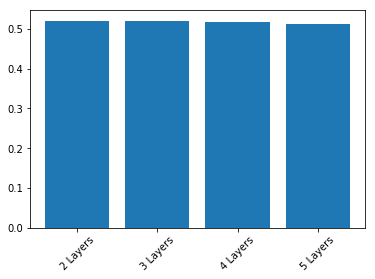

In [83]:
#Plot to show the best optimizer

score_list_reg_layers=[score_2l,score_3l, score_4l,score_5l]
names =['2 Layers','3 Layers','4 Layers', '5 Layers']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg_layers)), score_list_reg_layers)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# Activation Function - Sigmoid

## Training without early stopping and Model Checkpoint and Sigmoid 

In [84]:
# Tensorflow model for Regression with sigmoid
model_reg_sig = Sequential()

model_reg_sig.add(Dense(25, input_dim=x_train_reg.shape[1], activation='sigmoid'))  
model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 2
model_reg_sig.add(Dense(1)) # Output


In [85]:
# Model training with sigmoid 
model_reg_sig.compile(loss='mean_squared_error', optimizer='adam')
model_reg_sig.fit(x_train_reg,y_train_reg,verbose=2,epochs=100)

Epoch 1/100
 - 6s - loss: 4.0584
Epoch 2/100
 - 1s - loss: 1.1386
Epoch 3/100
 - 1s - loss: 1.0512
Epoch 4/100
 - 1s - loss: 1.0268
Epoch 5/100
 - 1s - loss: 0.9146
Epoch 6/100
 - 1s - loss: 0.6063
Epoch 7/100
 - 1s - loss: 0.3869
Epoch 8/100
 - 1s - loss: 0.3052
Epoch 9/100
 - 1s - loss: 0.2689
Epoch 10/100
 - 1s - loss: 0.2490
Epoch 11/100
 - 1s - loss: 0.2357
Epoch 12/100
 - 1s - loss: 0.2276
Epoch 13/100
 - 1s - loss: 0.2204
Epoch 14/100
 - 1s - loss: 0.2151
Epoch 15/100
 - 1s - loss: 0.2108
Epoch 16/100
 - 1s - loss: 0.2060
Epoch 17/100
 - 1s - loss: 0.2026
Epoch 18/100
 - 1s - loss: 0.1997
Epoch 19/100
 - 1s - loss: 0.1966
Epoch 20/100
 - 1s - loss: 0.1938
Epoch 21/100
 - 1s - loss: 0.1919
Epoch 22/100
 - 1s - loss: 0.1888
Epoch 23/100
 - 1s - loss: 0.1869
Epoch 24/100
 - 1s - loss: 0.1845
Epoch 25/100
 - 1s - loss: 0.1836
Epoch 26/100
 - 1s - loss: 0.1810
Epoch 27/100
 - 1s - loss: 0.1798
Epoch 28/100
 - 1s - loss: 0.1779
Epoch 29/100
 - 1s - loss: 0.1769
Epoch 30/100
 - 1s - lo

In [86]:
# Predict stars
pred_reg_sig_simple = model_reg_sig.predict(x_test_reg)
print("Shape: {}".format(pred_reg_sig_simple.shape))

Shape: (2000, 1)


In [87]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_sig_simple[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.0799503]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.0102205]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.6716404]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.2371492]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.3635006]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.914568]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.69597]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.202832]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.3296256]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.365282]


In [88]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_sig = np.sqrt(mean_squared_error(y_test_reg,pred_reg_sig_simple))
print("Final score (RMSE): {}".format(score_reg_sig))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_sig_simple))

Final score (RMSE): 0.5161359310150146
R2 score: 0.73


## Training with early stopping and Model Checkpoint and Sigmoid 

In [89]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid.hdf5", verbose=1, save_best_only=True)

In [90]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_sig = Sequential()

    model_reg_sig.add(Dense(120, input_dim=x_train_reg.shape[1], activation='sigmoid'))  
    model_reg_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_reg_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_reg_sig.add(Dense(1)) # Output
    model_reg_sig.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_sig.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_sig.load_weights('./best_weights_sigmoid.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 7s - loss: 2.4801 - val_loss: 1.1049

Epoch 00001: val_loss improved from inf to 1.10491, saving model to ./best_weights_sigmoid.hdf5
Epoch 2/100
 - 2s - loss: 1.0944 - val_loss: 0.9753

Epoch 00002: val_loss improved from 1.10491 to 0.97535, saving model to ./best_weights_sigmoid.hdf5
Epoch 3/100
 - 2s - loss: 1.0576 - val_loss: 0.9754

Epoch 00003: val_loss did not improve from 0.97535
Epoch 4/100
 - 3s - loss: 1.0572 - val_loss: 0.9751

Epoch 00004: val_loss improved from 0.97535 to 0.97514, saving model to ./best_weights_sigmoid.hdf5
Epoch 5/100
 - 3s - loss: 1.0573 - val_loss: 0.9756

Epoch 00005: val_loss did not improve from 0.97514
Epoch 00005: early stopping
1
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 9s - loss: 11.4972 - val_loss: 7.9403

Epoch 00001: val_loss did not improve from 0.97514
Epoch 2/100
 - 2s - loss: 6.9835 - val_loss: 5.7805

Epoch 00002: val_loss did not improve from 0.97514



Epoch 00014: val_loss did not improve from 0.24103
Epoch 15/100
 - 3s - loss: 0.1760 - val_loss: 0.2419

Epoch 00015: val_loss did not improve from 0.24103
Epoch 00015: early stopping
8
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 6s - loss: 1.3584 - val_loss: 0.9747

Epoch 00001: val_loss did not improve from 0.24103
Epoch 2/100
 - 2s - loss: 1.0568 - val_loss: 0.9745

Epoch 00002: val_loss did not improve from 0.24103
Epoch 3/100
 - 3s - loss: 1.0459 - val_loss: 0.9193

Epoch 00003: val_loss did not improve from 0.24103
Epoch 4/100
 - 2s - loss: 0.4968 - val_loss: 0.2962

Epoch 00004: val_loss did not improve from 0.24103
Epoch 5/100
 - 2s - loss: 0.2684 - val_loss: 0.2764

Epoch 00005: val_loss did not improve from 0.24103
Epoch 6/100
 - 2s - loss: 0.2442 - val_loss: 0.2620

Epoch 00006: val_loss did not improve from 0.24103
Epoch 7/100
 - 2s - loss: 0.2262 - val_loss: 0.2637

Epoch 00007: val_loss did not improve from 0.24103
Epoch 8/100
 - 3s - loss: 0.2156 - va

In [91]:
# Predict stars
pred_reg_sig_stopping = model_reg_sig.predict(x_test_reg)
print("Shape: {}".format(pred_reg_sig_stopping.shape))

Shape: (2000, 1)


In [92]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_sig_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.5, predicted Stars: [3.24848]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.881753]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.6787076]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.222487]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [4.2403736]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [4.709323]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.5, predicted Stars: [4.7718234]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.150016]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.1454115]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.5785422]


In [93]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_sig_stopping = np.sqrt(mean_squared_error(y_test_reg,pred_reg_sig_stopping))
print("Final score (RMSE): {}".format(score_reg_sig_stopping))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_sig_stopping))

Final score (RMSE): 0.4909469783306122
R2 score: 0.75


# Activation Function - Tanh

## Training without early stopping and Model Checkpoint and Tanh 

In [94]:
#train test data
x_train_reg_tanh, x_test_reg_tanh, y_train_reg_tanh, y_test_reg_tanh = train_test_split(x_matrix_zscore, y_stars_regression , test_size=0.2)


In [95]:
# Tensorflow model for Regression with tanh
model_reg_tanh = Sequential()

model_reg_tanh.add(Dense(25, input_dim=x_train_reg_tanh.shape[1], activation='tanh'))  
model_reg_tanh.add(Dense(10, activation='tanh')) # Hidden 2
model_reg_tanh.add(Dense(1)) # Output


In [96]:
# Model training with sigmoid 
model_reg_tanh.compile(loss='mean_squared_error', optimizer='adam')
model_reg_tanh.fit(x_train_reg_tanh,y_train_reg_tanh,verbose=2,epochs=100)

Epoch 1/100
 - 9s - loss: 2.2848
Epoch 2/100
 - 2s - loss: 0.8098
Epoch 3/100
 - 2s - loss: 0.3159
Epoch 4/100
 - 2s - loss: 0.2379
Epoch 5/100
 - 2s - loss: 0.2177
Epoch 6/100
 - 2s - loss: 0.2077
Epoch 7/100
 - 3s - loss: 0.2000
Epoch 8/100
 - 2s - loss: 0.1954
Epoch 9/100
 - 2s - loss: 0.1899
Epoch 10/100
 - 2s - loss: 0.1860
Epoch 11/100
 - 3s - loss: 0.1810
Epoch 12/100
 - 3s - loss: 0.1772
Epoch 13/100
 - 2s - loss: 0.1728
Epoch 14/100
 - 2s - loss: 0.1701
Epoch 15/100
 - 2s - loss: 0.1669
Epoch 16/100
 - 2s - loss: 0.1630
Epoch 17/100
 - 2s - loss: 0.1598
Epoch 18/100
 - 3s - loss: 0.1575
Epoch 19/100
 - 2s - loss: 0.1546
Epoch 20/100
 - 2s - loss: 0.1513
Epoch 21/100
 - 2s - loss: 0.1498
Epoch 22/100
 - 2s - loss: 0.1461
Epoch 23/100
 - 2s - loss: 0.1439
Epoch 24/100
 - 3s - loss: 0.1419
Epoch 25/100
 - 2s - loss: 0.1386
Epoch 26/100
 - 2s - loss: 0.1363
Epoch 27/100
 - 2s - loss: 0.1336
Epoch 28/100
 - 2s - loss: 0.1313
Epoch 29/100
 - 2s - loss: 0.1290
Epoch 30/100
 - 3s - lo

In [97]:
# Predict stars
pred_reg_tanh_simple = model_reg_tanh.predict(x_test_reg_tanh)
print("Shape: {}".format(pred_reg_tanh_simple.shape))

Shape: (2000, 1)


In [98]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg_tanh[i],pred_reg_tanh_simple[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.0, predicted Stars: [3.1018705]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 5.0, predicted Stars: [4.5146933]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [4.7276216]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [4.6877384]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [2.2276354]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.5, predicted Stars: [4.6085005]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 2.5, predicted Stars: [2.8314338]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.5, predicted Stars: [4.330737]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 2.0, predicted Stars: [1.3806022]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 1.0, predicted Stars: [1.8194293]


In [99]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_tanh = np.sqrt(mean_squared_error(y_test_reg_tanh,pred_reg_tanh_simple))
print("Final score (RMSE): {}".format(score_reg_tanh))
print('R2 score: %.2f' % r2_score(y_test_reg_tanh, pred_reg_tanh_simple))

Final score (RMSE): 0.6366003155708313
R2 score: 0.60


## Training with early stopping and Model Checkpoint and Tanh 

In [100]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh.hdf5", verbose=1, save_best_only=True)


In [101]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_tanh = Sequential()

    model_reg_tanh.add(Dense(120, input_dim=x_train_reg_tanh.shape[1], activation='tanh'))  
    model_reg_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_reg_tanh.add(Dense(40, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(20, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(1)) # Output
    model_reg_tanh.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_tanh.fit(x_train_reg_tanh,y_train_reg_tanh,validation_data=(x_test_reg_tanh,y_test_reg_tanh),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_tanh.load_weights('./best_weights_tanh.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 15s - loss: 0.8416 - val_loss: 0.2456

Epoch 00001: val_loss improved from inf to 0.24556, saving model to ./best_weights_tanh.hdf5
Epoch 2/100
 - 4s - loss: 0.2337 - val_loss: 0.2516

Epoch 00002: val_loss did not improve from 0.24556
Epoch 3/100
 - 3s - loss: 0.2123 - val_loss: 0.2373

Epoch 00003: val_loss improved from 0.24556 to 0.23731, saving model to ./best_weights_tanh.hdf5
Epoch 4/100
 - 3s - loss: 0.1987 - val_loss: 0.2385

Epoch 00004: val_loss did not improve from 0.23731
Epoch 5/100
 - 4s - loss: 0.1877 - val_loss: 0.2302

Epoch 00005: val_loss improved from 0.23731 to 0.23024, saving model to ./best_weights_tanh.hdf5
Epoch 6/100
 - 3s - loss: 0.1778 - val_loss: 0.2343

Epoch 00006: val_loss did not improve from 0.23024
Epoch 7/100
 - 3s - loss: 0.1698 - val_loss: 0.2333

Epoch 00007: val_loss did not improve from 0.23024
Epoch 8/100
 - 3s - loss: 0.1593 - val_loss: 0.2367

Epoch 00008: val_loss did not impr


Epoch 00010: val_loss did not improve from 0.22837
Epoch 00010: early stopping
Training finished...Loading the best model



In [102]:
# Predict stars
pred_reg_tanh_stopping = model_reg_tanh.predict(x_test_reg_tanh)
print("Shape: {}".format(pred_reg_tanh_stopping.shape))

Shape: (2000, 1)


In [103]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg_tanh[i],pred_reg_tanh_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.0, predicted Stars: [2.6935403]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 5.0, predicted Stars: [4.7206078]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.9964209]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [4.661306]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.7038476]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.5, predicted Stars: [4.876346]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 2.5, predicted Stars: [2.7314773]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.5, predicted Stars: [4.3106217]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 2.0, predicted Stars: [2.1593182]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 1.0, predicted Stars: [1.4617368]


In [104]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_tanh_stopping = np.sqrt(mean_squared_error(y_test_reg_tanh,pred_reg_tanh_stopping))
print("Final score (RMSE): {}".format(score_reg_tanh_stopping))
print('R2 score: %.2f' % r2_score(y_test_reg_tanh, pred_reg_tanh_stopping))

Final score (RMSE): 0.4778800308704376
R2 score: 0.78


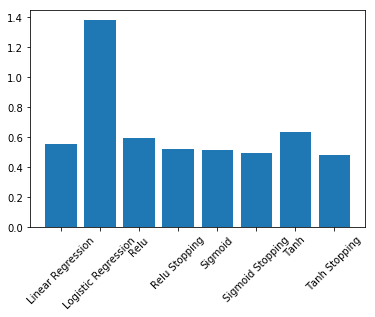

In [105]:
# plotting RMSE score for all regression models

score_list_reg=[score_lin_classic,score_log_classic,score_reg_relu,score_reg_relu_stopping,score_reg_sig,score_reg_sig_stopping,score_reg_tanh,score_reg_tanh_stopping]
names =['Linear Regression','Logistic Regression','Relu','Relu Stopping','Sigmoid','Sigmoid Stopping','Tanh','Tanh Stopping']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg)), score_list_reg)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

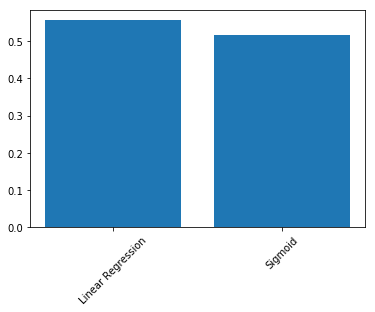

In [106]:
# plotting RMSE score for all regression models

score_list_reg=[score_lin_classic,score_reg_sig]
names =['Linear Regression','Sigmoid']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg)), score_list_reg)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

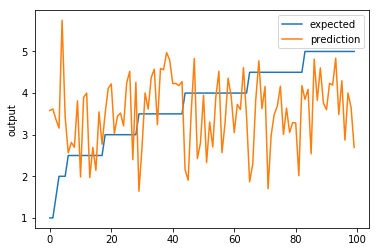

In [179]:
#Prediction for Sigmoid
chart_regression(pred_reg_stopping[0:100].flatten(),y_test_reg[0:100])

# Training and Prediction for Classification

In [107]:
#train test data for linear regression

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, merge_df['encoded_stars'] , test_size=0.2, random_state=42)


** KNN **

In [108]:
#implementing Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(x_train_lr, y_train_lr) 

y_pred_knn = knn.predict(x_test_lr)

In [109]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test_lr.index[i]
    print("business id - %s actual stars label - %d predicted - %d" 
          %(merge_df['business_id'][idx], y_test_lr[idx], y_pred_knn[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars label - 6 predicted - 8
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars label - 6 predicted - 4
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars label - 6 predicted - 6
business id - jrhc4s5XMR8S8kpGdU08og actual stars label - 7 predicted - 6
business id - e7207sqC-pSn6GIf31ikhQ actual stars label - 6 predicted - 6
business id - CF9TxeEdP5QxihYFAl4sUg actual stars label - 6 predicted - 6
business id - zZPCAFK85NtitSNVP_wfYg actual stars label - 5 predicted - 7
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars label - 8 predicted - 7
business id - TTrYd662CZFRPaiwl-sUqA actual stars label - 2 predicted - 4
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars label - 3 predicted - 6


In [110]:
# Metrics
from sklearn import metrics

score_knn_acc = metrics.accuracy_score(y_test_lr, y_pred_knn)
print("Accuracy score: {}".format(score_knn_acc))

score_knn_precision = metrics.precision_score(y_test_lr, y_pred_knn, average= "weighted")
print("Precision score: {}".format(score_knn_precision))

score_knn_recall = metrics.recall_score(y_test_lr, y_pred_knn, average= "weighted")
print("Recall score: {}".format(score_knn_recall))

score_knn_f1 = metrics.f1_score(y_test_lr, y_pred_knn, average= "weighted")
print("F1 score: {}".format(score_knn_f1))

Accuracy score: 0.295
Precision score: 0.2960480875614052
Recall score: 0.295
F1 score: 0.2918900582503685


** SVM **

In [111]:
# SVM

svm_model = SVC(kernel="linear")

svm_model.fit(x_train_lr, y_train_lr)

y_pred_svm = svm_model.predict(x_test_lr)

In [112]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test_lr.index[i]
    print("business id - %s actual stars label - %d predicted - %d" 
          %(merge_df['business_id'][idx], y_test_lr[idx], y_pred_svm[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars label - 6 predicted - 6
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars label - 6 predicted - 6
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars label - 6 predicted - 6
business id - jrhc4s5XMR8S8kpGdU08og actual stars label - 7 predicted - 7
business id - e7207sqC-pSn6GIf31ikhQ actual stars label - 6 predicted - 6
business id - CF9TxeEdP5QxihYFAl4sUg actual stars label - 6 predicted - 6
business id - zZPCAFK85NtitSNVP_wfYg actual stars label - 5 predicted - 5
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars label - 8 predicted - 8
business id - TTrYd662CZFRPaiwl-sUqA actual stars label - 2 predicted - 3
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars label - 3 predicted - 3


In [113]:
# Metrics

score_svm_acc = metrics.accuracy_score(y_test_lr, y_pred_svm)
print("Accuracy score: {}".format(score_svm_acc))

score_svm_precision = metrics.precision_score(y_test_lr, y_pred_svm, average= "weighted")
print("Precision score: {}".format(score_svm_precision))

score_svm_recall = metrics.recall_score(y_test_lr, y_pred_svm, average= "weighted")
print("Recall score: {}".format(score_svm_recall))

score_svm_f1 = metrics.f1_score(y_test_lr, y_pred_svm, average= "weighted")
print("F1 score: {}".format(score_svm_f1))

Accuracy score: 0.4365
Precision score: 0.43072237226007926
Recall score: 0.4365
F1 score: 0.4278230138666609


** MNB **

In [114]:
mnb_model = MultinomialNB()

mnb_model.fit(x_train_lr, y_train_lr)

y_pred_mnb = mnb_model.predict(x_test_lr)

In [115]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test_lr.index[i]
    print("business id - %s actual stars label - %d predicted - %d" 
          %(merge_df['business_id'][idx], y_test_lr[idx], y_pred_mnb[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars label - 6 predicted - 8
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars label - 6 predicted - 6
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars label - 6 predicted - 6
business id - jrhc4s5XMR8S8kpGdU08og actual stars label - 7 predicted - 7
business id - e7207sqC-pSn6GIf31ikhQ actual stars label - 6 predicted - 6
business id - CF9TxeEdP5QxihYFAl4sUg actual stars label - 6 predicted - 8
business id - zZPCAFK85NtitSNVP_wfYg actual stars label - 5 predicted - 8
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars label - 8 predicted - 8
business id - TTrYd662CZFRPaiwl-sUqA actual stars label - 2 predicted - 3
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars label - 3 predicted - 0


In [116]:
# Metrics

score_mnb_acc = metrics.accuracy_score(y_test_lr, y_pred_mnb)
print("Accuracy score: {}".format(score_mnb_acc))

score_mnb_precision = metrics.precision_score(y_test_lr, y_pred_mnb, average= "weighted")
print("Precision score: {}".format(score_mnb_precision))

score_mnb_recall = metrics.recall_score(y_test_lr, y_pred_mnb, average= "weighted")
print("Recall score: {}".format(score_mnb_recall))

score_mnb_f1 = metrics.f1_score(y_test_lr, y_pred_mnb, average= "weighted")
print("F1 score: {}".format(score_mnb_f1))

Accuracy score: 0.3325
Precision score: 0.29977451126707483
Recall score: 0.3325
F1 score: 0.2831433707336793


# Tensorflow for Classification

**  Activation ReLU, Optimizer adam with stopping and checkpoint **

In [117]:
# Encoding stars 

hotcoded_stars_df = pd.get_dummies(merge_df['encoded_stars'], sparse = 'true')

In [118]:
y_stars_encoded = hotcoded_stars_df.values.astype(np.float32)

In [119]:
#train test data for classification

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, y_stars_encoded, test_size=0.2, random_state=42)


In [120]:
# set up checkpointer
checkpointer_classification = ModelCheckpoint(filepath="./best_weights_softmax.hdf5", verbose=1, save_best_only=True)

In [121]:
#Tensorflow classification
for i in range(10):
    print(i)
    
    # Build network
    model_classification = Sequential()
    model_classification.add(Dense(50, input_dim=x_train_lr.shape[1], activation='relu')) # Hidden 1
    model_classification.add(Dense(25, activation='relu')) # Hidden 2
    model_classification.add(Dense(y_train_lr.shape[1], activation='softmax')) # Output
    model_classification.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model_classification.fit(x_train_lr,y_train_lr,validation_data=(x_test_lr,y_test_lr),callbacks=[monitor,checkpointer_classification],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_classification.load_weights('./best_weights_softmax.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 8s - loss: 1.7959 - val_loss: 1.4505

Epoch 00001: val_loss improved from inf to 1.45049, saving model to ./best_weights_softmax.hdf5
Epoch 2/100
 - 2s - loss: 1.3058 - val_loss: 1.2739

Epoch 00002: val_loss improved from 1.45049 to 1.27392, saving model to ./best_weights_softmax.hdf5
Epoch 3/100
 - 2s - loss: 1.1656 - val_loss: 1.2378

Epoch 00003: val_loss improved from 1.27392 to 1.23780, saving model to ./best_weights_softmax.hdf5
Epoch 4/100
 - 2s - loss: 1.0929 - val_loss: 1.2401

Epoch 00004: val_loss did not improve from 1.23780
Epoch 5/100
 - 2s - loss: 1.0442 - val_loss: 1.2510

Epoch 00005: val_loss did not improve from 1.23780
Epoch 6/100
 - 1s - loss: 0.9955 - val_loss: 1.2537

Epoch 00006: val_loss did not improve from 1.23780
Epoch 7/100
 - 2s - loss: 0.9575 - val_loss: 1.2779

Epoch 00007: val_loss did not improve from 1.23780
Epoch 8/100
 - 2s - loss: 0.9166 - val_loss: 1.3053

Epoch 00008: val_loss did 

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 7s - loss: 1.7763 - val_loss: 1.4221

Epoch 00001: val_loss did not improve from 1.23467
Epoch 2/100
 - 2s - loss: 1.2925 - val_loss: 1.2744

Epoch 00002: val_loss did not improve from 1.23467
Epoch 3/100
 - 2s - loss: 1.1733 - val_loss: 1.2403

Epoch 00003: val_loss did not improve from 1.23467
Epoch 4/100
 - 2s - loss: 1.1130 - val_loss: 1.2308

Epoch 00004: val_loss improved from 1.23467 to 1.23076, saving model to ./best_weights_softmax.hdf5
Epoch 5/100
 - 2s - loss: 1.0659 - val_loss: 1.2448

Epoch 00005: val_loss did not improve from 1.23076
Epoch 6/100
 - 2s - loss: 1.0265 - val_loss: 1.2616

Epoch 00006: val_loss did not improve from 1.23076
Epoch 7/100
 - 2s - loss: 0.9906 - val_loss: 1.2731

Epoch 00007: val_loss did not improve from 1.23076
Epoch 8/100
 - 2s - loss: 0.9532 - val_loss: 1.2830

Epoch 00008: val_loss did not improve from 1.23076
Epoch 9/100
 - 2s - loss: 0.9179 - val_loss: 1.3009

Epoch 00009: val_l

In [122]:
pred_class = model_classification.predict(x_test_lr)
print("Shape: {}".format(pred_class.shape))
print(pred_class)

Shape: (2000, 9)
[[1.57125442e-06 3.69864756e-05 3.72855255e-04 ... 4.69381094e-01
  8.04057717e-02 8.68645962e-03]
 [6.61713706e-09 1.00357943e-06 2.85136102e-05 ... 5.67960978e-01
  6.79508969e-02 2.83170491e-03]
 [6.42697913e-08 2.51377787e-06 2.37257864e-05 ... 4.19736505e-01
  3.43536168e-01 1.01730205e-01]
 ...
 [7.86424056e-03 7.96710700e-02 3.31100374e-01 ... 2.20426053e-04
  2.06276991e-06 2.48024108e-08]
 [1.39642442e-02 4.28913832e-02 1.21607192e-01 ... 3.21689360e-02
  5.17557329e-03 6.98405609e-04]
 [4.68939447e-08 4.24472864e-06 1.00527162e-04 ... 5.09665132e-01
  5.90828583e-02 3.58550926e-03]]


In [123]:
predict_stars = np.argmax(pred_class,axis=1)
true_stars = np.argmax(y_test_lr,axis=1)

In [124]:
for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],true_stars[i],predict_stars[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 6, predicted Stars: 6
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 6, predicted Stars: 6
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 6, predicted Stars: 6
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 7, predicted Stars: 7
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 6, predicted Stars: 6
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 6, predicted Stars: 6
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 5, predicted Stars: 5
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 8, predicted Stars: 8
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 2, predicted Stars: 3
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 3, predicted Stars: 3


In [125]:
# Metrics

score_tf_acc_stopping = metrics.accuracy_score(true_stars, predict_stars)
print("Accuracy score: {}".format(score_tf_acc_stopping))

score_tf_precision_stopping = metrics.precision_score(true_stars, predict_stars, average= "weighted")
print("Precision score: {}".format(score_tf_precision_stopping))

score_tf_recall_stopping = metrics.recall_score(true_stars, predict_stars, average= "weighted")
print("Recall score: {}".format(score_tf_recall_stopping))

score_tf_f1_stopping = metrics.f1_score(true_stars, predict_stars, average= "weighted")
print("F1 score: {}".format(score_tf_f1_stopping))

Accuracy score: 0.486
Precision score: 0.47548869999990334
Recall score: 0.486
F1 score: 0.47420108580812714


** Classification with Sigmoid **

In [126]:
#train test data for classification

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, y_stars_encoded, test_size=0.2, random_state=42)


In [127]:
# set up checkpointer
checkpointer_classification_sig = ModelCheckpoint(filepath="./best_weights_softmax_sig.hdf5", verbose=1, save_best_only=True)

In [128]:
#Tensorflow classification
for i in range(10):
    print(i)
    
    # Build network
    model_classification = Sequential()
    model_classification.add(Dense(50, input_dim=x_train_lr.shape[1], activation='sigmoid')) # Hidden 1
    model_classification.add(Dense(25, activation='sigmoid')) # Hidden 2
    model_classification.add(Dense(y_train_lr.shape[1], activation='softmax')) # Output
    model_classification.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model_classification.fit(x_train_lr,y_train_lr,validation_data=(x_test_lr,y_test_lr),callbacks=[monitor,checkpointer_classification_sig],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_classification.load_weights('./best_weights_softmax_sig.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 8s - loss: 2.0628 - val_loss: 2.0041

Epoch 00001: val_loss improved from inf to 2.00407, saving model to ./best_weights_softmax_sig.hdf5
Epoch 2/100
 - 2s - loss: 1.9567 - val_loss: 1.8903

Epoch 00002: val_loss improved from 2.00407 to 1.89027, saving model to ./best_weights_softmax_sig.hdf5
Epoch 3/100
 - 3s - loss: 1.7827 - val_loss: 1.6956

Epoch 00003: val_loss improved from 1.89027 to 1.69557, saving model to ./best_weights_softmax_sig.hdf5
Epoch 4/100
 - 2s - loss: 1.6031 - val_loss: 1.5357

Epoch 00004: val_loss improved from 1.69557 to 1.53569, saving model to ./best_weights_softmax_sig.hdf5
Epoch 5/100
 - 2s - loss: 1.4699 - val_loss: 1.4360

Epoch 00005: val_loss improved from 1.53569 to 1.43604, saving model to ./best_weights_softmax_sig.hdf5
Epoch 6/100
 - 2s - loss: 1.3885 - val_loss: 1.3779

Epoch 00006: val_loss improved from 1.43604 to 1.37785, saving model to ./best_weights_softmax_sig.hdf5
Epoch 7/100


 - 2s - loss: 1.9369 - val_loss: 1.8580

Epoch 00002: val_loss did not improve from 1.24305
Epoch 3/100
 - 3s - loss: 1.7418 - val_loss: 1.6421

Epoch 00003: val_loss did not improve from 1.24305
Epoch 4/100
 - 2s - loss: 1.5628 - val_loss: 1.5059

Epoch 00004: val_loss did not improve from 1.24305
Epoch 5/100
 - 2s - loss: 1.4585 - val_loss: 1.4328

Epoch 00005: val_loss did not improve from 1.24305
Epoch 6/100
 - 2s - loss: 1.3910 - val_loss: 1.3863

Epoch 00006: val_loss did not improve from 1.24305
Epoch 7/100
 - 2s - loss: 1.3402 - val_loss: 1.3514

Epoch 00007: val_loss did not improve from 1.24305
Epoch 8/100
 - 2s - loss: 1.3007 - val_loss: 1.3232

Epoch 00008: val_loss did not improve from 1.24305
Epoch 9/100
 - 2s - loss: 1.2656 - val_loss: 1.3055

Epoch 00009: val_loss did not improve from 1.24305
Epoch 10/100
 - 2s - loss: 1.2377 - val_loss: 1.2864

Epoch 00010: val_loss did not improve from 1.24305
Epoch 11/100
 - 2s - loss: 1.2122 - val_loss: 1.2790

Epoch 00011: val_loss


Epoch 00013: val_loss did not improve from 1.24305
Epoch 14/100
 - 2s - loss: 1.1469 - val_loss: 1.2524

Epoch 00014: val_loss did not improve from 1.24305
Epoch 15/100
 - 2s - loss: 1.1315 - val_loss: 1.2492

Epoch 00015: val_loss did not improve from 1.24305
Epoch 16/100
 - 2s - loss: 1.1157 - val_loss: 1.2469

Epoch 00016: val_loss did not improve from 1.24305
Epoch 17/100
 - 3s - loss: 1.1015 - val_loss: 1.2469

Epoch 00017: val_loss did not improve from 1.24305
Epoch 18/100
 - 2s - loss: 1.0894 - val_loss: 1.2471

Epoch 00018: val_loss did not improve from 1.24305
Epoch 19/100
 - 2s - loss: 1.0770 - val_loss: 1.2477

Epoch 00019: val_loss did not improve from 1.24305
Epoch 20/100
 - 2s - loss: 1.0653 - val_loss: 1.2505

Epoch 00020: val_loss did not improve from 1.24305
Epoch 21/100
 - 2s - loss: 1.0548 - val_loss: 1.2573

Epoch 00021: val_loss did not improve from 1.24305
Epoch 00021: early stopping
7
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 8s - loss: 2.03

In [129]:
pred_softmax_sig = model_classification.predict(x_test_lr)
print("Shape: {}".format(pred_softmax_sig.shape))
print(pred_softmax_sig)

Shape: (2000, 9)
[[2.6428386e-05 6.6561646e-05 7.2737178e-04 ... 4.8010001e-01
  8.4608644e-02 5.6764153e-03]
 [7.1267641e-06 2.3806502e-05 3.0396684e-04 ... 5.5357748e-01
  9.2104904e-02 3.4559101e-03]
 [2.6218740e-06 6.3406983e-06 4.7278310e-05 ... 3.3798721e-01
  4.8585954e-01 9.7511649e-02]
 ...
 [5.2497108e-02 1.1034695e-01 2.7520877e-01 ... 3.7755424e-03
  4.2102387e-04 8.3321484e-06]
 [9.8571796e-03 1.6618140e-02 8.0279812e-02 ... 5.3628657e-02
  9.1221323e-03 5.2331603e-04]
 [1.9931931e-05 6.4284206e-05 7.9478079e-04 ... 3.8323784e-01
  4.5505017e-02 2.5554695e-03]]


In [130]:
predict_stars = np.argmax(pred_softmax_sig,axis=1)
true_stars = np.argmax(y_test_lr,axis=1)

In [131]:
for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],true_stars[i],predict_stars[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 6, predicted Stars: 6
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 6, predicted Stars: 6
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 6, predicted Stars: 7
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 7, predicted Stars: 7
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 6, predicted Stars: 6
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 6, predicted Stars: 6
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 5, predicted Stars: 5
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 8, predicted Stars: 8
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 2, predicted Stars: 3
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 3, predicted Stars: 3


In [132]:
# Metrics

score_acc_softmax_sig = metrics.accuracy_score(true_stars, predict_stars)
print("Accuracy score: {}".format(score_acc_softmax_sig))

score_precision_softmax_sig = metrics.precision_score(true_stars, predict_stars, average= "weighted")
print("Precision score: {}".format(score_precision_softmax_sig))

score_recall_softmax_sig = metrics.recall_score(true_stars, predict_stars, average= "weighted")
print("Recall score: {}".format(score_recall_softmax_sig))

score_f1_softmax_sig = metrics.f1_score(true_stars, predict_stars, average= "weighted")
print("F1 score: {}".format(score_f1_softmax_sig))

Accuracy score: 0.4915
Precision score: 0.47394875547054105
Recall score: 0.4915
F1 score: 0.48090283018481284


C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


** Classification with Tanh **

In [133]:
# set up checkpointer
checkpointer_classification_tanh = ModelCheckpoint(filepath="./best_weights_softmax_tanh.hdf5", verbose=1, save_best_only=True)

In [134]:
#Tensorflow classification
for i in range(10):
    print(i)
    
    # Build network
    model_classification = Sequential()
    model_classification.add(Dense(50, input_dim=x_train_lr.shape[1], activation='tanh')) # Hidden 1
    model_classification.add(Dense(25, activation='tanh')) # Hidden 2
    model_classification.add(Dense(y_train_lr.shape[1], activation='softmax')) # Output
    model_classification.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model_classification.fit(x_train_lr,y_train_lr,validation_data=(x_test_lr,y_test_lr),callbacks=[monitor,checkpointer_classification_tanh],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_classification.load_weights('./best_weights_softmax_tanh.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 8s - loss: 1.7209 - val_loss: 1.4131

Epoch 00001: val_loss improved from inf to 1.41310, saving model to ./best_weights_softmax_tanh.hdf5
Epoch 2/100
 - 2s - loss: 1.2957 - val_loss: 1.2751

Epoch 00002: val_loss improved from 1.41310 to 1.27507, saving model to ./best_weights_softmax_tanh.hdf5
Epoch 3/100
 - 3s - loss: 1.1763 - val_loss: 1.2436

Epoch 00003: val_loss improved from 1.27507 to 1.24358, saving model to ./best_weights_softmax_tanh.hdf5
Epoch 4/100
 - 3s - loss: 1.1064 - val_loss: 1.2450

Epoch 00004: val_loss did not improve from 1.24358
Epoch 5/100
 - 3s - loss: 1.0568 - val_loss: 1.2562

Epoch 00005: val_loss did not improve from 1.24358
Epoch 6/100
 - 3s - loss: 1.0103 - val_loss: 1.2773

Epoch 00006: val_loss did not improve from 1.24358
Epoch 7/100
 - 4s - loss: 0.9727 - val_loss: 1.3041

Epoch 00007: val_loss did not improve from 1.24358
Epoch 8/100
 - 3s - loss: 0.9391 - val_loss: 1.3219

Epoch 00008

 - 3s - loss: 1.1017 - val_loss: 1.2521

Epoch 00004: val_loss did not improve from 1.23301
Epoch 5/100
 - 2s - loss: 1.0468 - val_loss: 1.2629

Epoch 00005: val_loss did not improve from 1.23301
Epoch 6/100
 - 3s - loss: 0.9996 - val_loss: 1.2909

Epoch 00006: val_loss did not improve from 1.23301
Epoch 7/100
 - 3s - loss: 0.9606 - val_loss: 1.3178

Epoch 00007: val_loss did not improve from 1.23301
Epoch 8/100
 - 3s - loss: 0.9241 - val_loss: 1.3449

Epoch 00008: val_loss did not improve from 1.23301
Epoch 9/100
 - 2s - loss: 0.8924 - val_loss: 1.3882

Epoch 00009: val_loss did not improve from 1.23301
Epoch 00009: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 9s - loss: 1.6647 - val_loss: 1.3781

Epoch 00001: val_loss did not improve from 1.23301
Epoch 2/100
 - 3s - loss: 1.2870 - val_loss: 1.2728

Epoch 00002: val_loss did not improve from 1.23301
Epoch 3/100
 - 3s - loss: 1.1801 - val_loss: 1.2467

Epoch 00003: val_loss did not improve from 1.2330

In [135]:
pred_class_tanh = model_classification.predict(x_test_lr)
print("Shape: {}".format(pred_class_tanh.shape))
print(pred_class_tanh)

Shape: (2000, 9)
[[2.9309979e-04 7.6368195e-04 3.1096060e-03 ... 3.5218918e-01
  7.3664486e-02 8.2561085e-03]
 [3.5263372e-05 1.9878068e-04 7.2009966e-04 ... 4.3902308e-01
  9.6078582e-02 4.3154527e-03]
 [4.7294710e-05 1.5183951e-04 4.9645797e-04 ... 3.8862678e-01
  3.9821169e-01 6.5379322e-02]
 ...
 [9.0967201e-02 1.5227582e-01 2.4234036e-01 ... 1.4888047e-03
  1.4658453e-04 4.6561631e-06]
 [4.3624546e-02 6.2864169e-02 1.3514607e-01 ... 3.3515919e-02
  6.8771937e-03 5.9607241e-04]
 [8.0422702e-05 4.6633021e-04 1.7533089e-03 ... 3.8126311e-01
  6.2727369e-02 3.2474271e-03]]


In [136]:
predict_stars_tanh = np.argmax(pred_class_tanh,axis=1)
true_stars = np.argmax(y_test_lr,axis=1)

In [137]:
for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],true_stars[i],predict_stars_tanh[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 6, predicted Stars: 5
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 6, predicted Stars: 6
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 6, predicted Stars: 7
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 7, predicted Stars: 7
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 6, predicted Stars: 6
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 6, predicted Stars: 6
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 5, predicted Stars: 5
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 8, predicted Stars: 8
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 2, predicted Stars: 3
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 3, predicted Stars: 3


In [138]:
# Metrics

score_tf_acc_tanh = metrics.accuracy_score(true_stars, predict_stars_tanh)
print("Accuracy score: {}".format(score_tf_acc_tanh))

score_tf_precision_tanh = metrics.precision_score(true_stars, predict_stars_tanh, average= "weighted")
print("Precision score: {}".format(score_tf_precision_tanh))

score_tf_recall_tanh = metrics.recall_score(true_stars, predict_stars_tanh, average= "weighted")
print("Recall score: {}".format(score_tf_recall_tanh))

score_tf_f1_tanh = metrics.f1_score(true_stars, predict_stars_tanh, average= "weighted")
print("F1 score: {}".format(score_tf_f1_tanh))

Accuracy score: 0.494
Precision score: 0.49170562004997825
Recall score: 0.494
F1 score: 0.4857120550063005


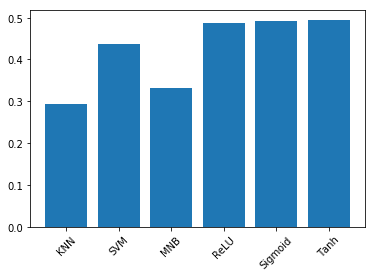

In [139]:
# plotting accuracy score for all classification models

score_list_reg=[score_knn_acc,score_svm_acc,score_mnb_acc,score_tf_acc_stopping,score_acc_softmax_sig,score_tf_acc_tanh]
names =['KNN','SVM','MNB','ReLU','Sigmoid','Tanh']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg)), score_list_reg)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

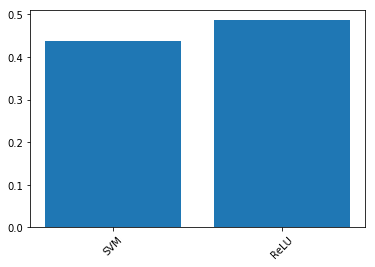

In [140]:

score_list_reg=[score_svm_acc,score_tf_acc_stopping]
names =['SVM','ReLU']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg)), score_list_reg)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# Additional Features

In [141]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn import metrics
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.models import Sequential

In [142]:
#train test data
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_matrix_minmax, y_stars_regression , test_size=0.2)

In [143]:
#USe linear regression for regularization
model_regularization = Sequential()
model_regularization.add(Dense(50, input_dim=x_train_reg.shape[1], activation='relu'))
model_regularization.add(Dense(25, activation='relu'))
model_regularization.add(Dense(10, 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01), activation='relu'))
model_regularization.add(Dense(1)) 
model_regularization.compile(loss='mean_squared_error', optimizer='adam')

In [144]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model_regularization.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor],verbose=2,epochs=100)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 10s - loss: 5.6602 - val_loss: 2.8496
Epoch 2/100
 - 3s - loss: 2.3152 - val_loss: 1.9242
Epoch 3/100
 - 3s - loss: 1.6785 - val_loss: 1.5149
Epoch 4/100
 - 3s - loss: 1.3359 - val_loss: 1.2629
Epoch 5/100
 - 3s - loss: 1.1036 - val_loss: 1.0700
Epoch 6/100
 - 3s - loss: 0.9203 - val_loss: 0.9381
Epoch 7/100
 - 3s - loss: 0.7725 - val_loss: 0.8318
Epoch 8/100
 - 3s - loss: 0.6581 - val_loss: 0.7528
Epoch 9/100
 - 3s - loss: 0.5648 - val_loss: 0.6943
Epoch 10/100
 - 3s - loss: 0.4888 - val_loss: 0.6444
Epoch 11/100
 - 3s - loss: 0.4258 - val_loss: 0.6077
Epoch 12/100
 - 3s - loss: 0.3740 - val_loss: 0.5708
Epoch 13/100
 - 3s - loss: 0.3299 - val_loss: 0.5450
Epoch 14/100
 - 3s - loss: 0.2927 - val_loss: 0.5198
Epoch 15/100
 - 3s - loss: 0.2596 - val_loss: 0.4926
Epoch 16/100
 - 3s - loss: 0.2337 - val_loss: 0.4739
Epoch 17/100
 - 3s - loss: 0.2118 - val_loss: 0.4574
Epoch 18/100
 - 3s - loss: 0.1932 - val_loss: 0.4441
Epoch 

In [145]:
pred_regularization = model_regularization.predict(x_test_reg)

In [146]:
# Measure RMSE error.  RMSE is common for regression.
score_regularization = np.sqrt(metrics.mean_squared_error(pred_regularization,y_test_reg))
print("Final score (RMSE): {}".format(score_regularization))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_regularization))

Final score (RMSE): 0.557976484298706
R2 score: 0.71


** DROPOUT **

In [147]:
# Dropout

model_dropout = Sequential()
model_dropout.add(Dense(50, input_dim=x_train_reg.shape[1]))
model_dropout.add(Dropout(0.1))

model_dropout.add(Dense(25, activation='relu'))
model_dropout.add(Dense(10, activation='relu'))
model_dropout.add(Dense(1))

model_dropout.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model_dropout.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor],verbose=0,epochs=1000)

Epoch 00021: early stopping


In [148]:
pred_dropout = model_dropout.predict(x_test_reg)

In [149]:
# Measure RMSE error.  RMSE is common for regression.
score_dropout = np.sqrt(metrics.mean_squared_error(pred_dropout,y_test_reg))
print("Final score (RMSE): {}".format(score_dropout))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_dropout))

Final score (RMSE): 0.5267772078514099
R2 score: 0.74


In [150]:
model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_594 (Dense)            (None, 50)                50100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_595 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_596 (Dense)            (None, 10)                260       
_________________________________________________________________
dense_597 (Dense)            (None, 1)                 11        
Total params: 51,646
Trainable params: 51,646
Non-trainable params: 0
_________________________________________________________________


** Regularization and dropout with Postal and categories **

In [152]:
# one-hot cooding of postal codes 

postal_hotcoded_df = pd.get_dummies(merge_df['postal code'], sparse = 'true')

x_matrix_postal = np.column_stack((x_matrix_minmax, postal_hotcoded_df))
x_matrix_final = np.column_stack((x_matrix_postal, category_matrix))

In [153]:
#Checking to see if regularization helps with over fitting when using postal code and categories and one hot coded values
#train test data
x_train_reg_ad, x_test_reg_ad, y_train_reg_ad, y_test_reg_ad = train_test_split(x_matrix_final, y_stars_regression , test_size=0.2)


In [154]:

#USe linear regression for regularization
model_regularization_ad = Sequential()
model_regularization_ad.add(Dense(50, input_dim=x_train_reg_ad.shape[1], activation='relu'))
model_regularization_ad.add(Dense(25, activation='relu'))
model_regularization_ad.add(Dense(10, 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01), activation='relu'))
model_regularization_ad.add(Dense(1)) 
model_regularization_ad.compile(loss='mean_squared_error', optimizer='adam')

In [155]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model_regularization_ad.fit(x_train_reg_ad,y_train_reg_ad,validation_data=(x_test_reg_ad,y_test_reg_ad),callbacks=[monitor],verbose=2,epochs=100)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 12s - loss: 5.1199 - val_loss: 2.9405
Epoch 2/100
 - 5s - loss: 2.1971 - val_loss: 1.7155
Epoch 3/100
 - 5s - loss: 1.3299 - val_loss: 1.3006
Epoch 4/100
 - 4s - loss: 1.0018 - val_loss: 1.1061
Epoch 5/100
 - 5s - loss: 0.8066 - val_loss: 0.9616
Epoch 6/100
 - 5s - loss: 0.6680 - val_loss: 0.8667
Epoch 7/100
 - 5s - loss: 0.5589 - val_loss: 0.7894
Epoch 8/100
 - 4s - loss: 0.4736 - val_loss: 0.7381
Epoch 9/100
 - 4s - loss: 0.4071 - val_loss: 0.6979
Epoch 10/100
 - 5s - loss: 0.3541 - val_loss: 0.6550
Epoch 11/100
 - 5s - loss: 0.3104 - val_loss: 0.6217
Epoch 12/100
 - 5s - loss: 0.2726 - val_loss: 0.5894
Epoch 13/100
 - 4s - loss: 0.2408 - val_loss: 0.5679
Epoch 14/100
 - 4s - loss: 0.2137 - val_loss: 0.5478
Epoch 15/100
 - 5s - loss: 0.1912 - val_loss: 0.5220
Epoch 16/100
 - 5s - loss: 0.1721 - val_loss: 0.5016
Epoch 17/100
 - 6s - loss: 0.1562 - val_loss: 0.4889
Epoch 18/100
 - 6s - loss: 0.1412 - val_loss: 0.4758
Epoch 

In [156]:
pred_regularization_ad = model_regularization_ad.predict(x_test_reg_ad)

In [157]:
# Measure RMSE error.  RMSE is common for regression.
score_regularization_ad = np.sqrt(metrics.mean_squared_error(pred_regularization_ad,y_test_reg_ad))
print("Final score (RMSE): {}".format(score_regularization_ad))
print('R2 score: %.2f' % r2_score(y_test_reg_ad, pred_regularization_ad))

Final score (RMSE): 0.5929731130599976
R2 score: 0.66


In [158]:
# Dropout

model_dropout_ad = Sequential()
model_dropout_ad.add(Dense(50, input_dim=x_train_reg_ad.shape[1]))
model_dropout_ad.add(Dropout(0.1))

model_dropout_ad.add(Dense(25, activation='relu'))
model_dropout_ad.add(Dense(10, activation='relu'))
model_dropout_ad.add(Dense(1))

model_dropout_ad.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model_dropout_ad.fit(x_train_reg_ad,y_train_reg_ad,validation_data=(x_test_reg_ad,y_test_reg_ad),callbacks=[monitor],verbose=0,epochs=1000)

Epoch 00010: early stopping


In [159]:
pred_dropout_ad = model_dropout_ad.predict(x_test_reg_ad)

In [160]:
# Measure RMSE error.  RMSE is common for regression.
score_dropout_ad = np.sqrt(metrics.mean_squared_error(pred_dropout_ad,y_test_reg_ad))
print("Final score (RMSE): {}".format(score_dropout_ad))
print('R2 score: %.2f' % r2_score(y_test_reg_ad, pred_dropout_ad))

Final score (RMSE): 0.6190357208251953
R2 score: 0.63


In [161]:
model_dropout_ad.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_602 (Dense)            (None, 50)                275650    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_603 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_604 (Dense)            (None, 10)                260       
_________________________________________________________________
dense_605 (Dense)            (None, 1)                 11        
Total params: 277,196
Trainable params: 277,196
Non-trainable params: 0
_________________________________________________________________


** Relu with Postal Code and Categories **

In [162]:
# one-hot cooding of postal codes 

postal_hotcoded_df = pd.get_dummies(merge_df['postal code'], sparse = 'true')

x_matrix_postal = np.column_stack((x_matrix_minmax, postal_hotcoded_df))
x_matrix_final = np.column_stack((x_matrix_postal, category_matrix))



In [163]:
print(y_stars_regression.shape)


(10000,)


In [164]:
#train test data
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_matrix_final, y_stars_regression , test_size=0.2)

In [165]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_postal.hdf5", verbose=1, save_best_only=True)


In [166]:
#ReLU
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_postal.hdf5')


0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 11s - loss: 1.9413 - val_loss: 0.4421

Epoch 00001: val_loss improved from inf to 0.44208, saving model to ./best_weights_relu_postal.hdf5
Epoch 2/100
 - 4s - loss: 0.3170 - val_loss: 0.3742

Epoch 00002: val_loss improved from 0.44208 to 0.37424, saving model to ./best_weights_relu_postal.hdf5
Epoch 3/100
 - 5s - loss: 0.2093 - val_loss: 0.3575

Epoch 00003: val_loss improved from 0.37424 to 0.35753, saving model to ./best_weights_relu_postal.hdf5
Epoch 4/100
 - 5s - loss: 0.1638 - val_loss: 0.3651

Epoch 00004: val_loss did not improve from 0.35753
Epoch 5/100
 - 4s - loss: 0.1313 - val_loss: 0.3673

Epoch 00005: val_loss did not improve from 0.35753
Epoch 6/100
 - 5s - loss: 0.1028 - val_loss: 0.3779

Epoch 00006: val_loss did not improve from 0.35753
Epoch 7/100
 - 4s - loss: 0.0800 - val_loss: 0.3782

Epoch 00007: val_loss did not improve from 0.35753
Epoch 8/100
 - 4s - loss: 0.0617 - val_loss: 0.3743

Epoch 00008: 


Epoch 00006: val_loss did not improve from 0.35337
Epoch 7/100
 - 5s - loss: 0.0950 - val_loss: 0.3819

Epoch 00007: val_loss did not improve from 0.35337
Epoch 8/100
 - 6s - loss: 0.0785 - val_loss: 0.3825

Epoch 00008: val_loss did not improve from 0.35337
Epoch 9/100
 - 7s - loss: 0.0659 - val_loss: 0.3955

Epoch 00009: val_loss did not improve from 0.35337
Epoch 00009: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 13s - loss: 1.9074 - val_loss: 0.4366

Epoch 00001: val_loss did not improve from 0.35337
Epoch 2/100
 - 5s - loss: 0.3191 - val_loss: 0.3612

Epoch 00002: val_loss did not improve from 0.35337
Epoch 3/100
 - 5s - loss: 0.2128 - val_loss: 0.3630

Epoch 00003: val_loss did not improve from 0.35337
Epoch 4/100
 - 5s - loss: 0.1684 - val_loss: 0.3515

Epoch 00004: val_loss improved from 0.35337 to 0.35147, saving model to ./best_weights_relu_postal.hdf5
Epoch 5/100
 - 6s - loss: 0.1350 - val_loss: 0.3645

Epoch 00005: val_loss did not impro

In [167]:
# Predict stars relu
pred_reg_relu_stopping = model_reg_relu.predict(x_test_reg)
print("Shape: {}".format(pred_reg_relu_stopping.shape))

Shape: (2000, 1)


In [168]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_relu_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 2.0, predicted Stars: [2.439553]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 2.5, predicted Stars: [3.9701362]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.390435]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 3.5, predicted Stars: [3.002405]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [3.9543777]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [5.473566]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [3.4923892]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 2.5, predicted Stars: [2.116056]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.3660235]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 5.0, predicted Stars: [4.863983]


In [169]:
score_relu_postal = np.sqrt(mean_squared_error(y_test_reg,pred_reg_relu_stopping))
print("Final score (RMSE): {}".format(score_relu_postal))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_relu_stopping))

Final score (RMSE): 0.5928520560264587
R2 score: 0.65


In [170]:
#Checkpointer sigmoid
checkpointer_sigmoid_postal = ModelCheckpoint(filepath="./best_weights_sigmoid_postal.hdf5", verbose=1, save_best_only=True)

In [171]:
#Sigmoid
for i in range(10):
    print(i)
    
    # Build network
    model_reg_sigmoid = Sequential()

    model_reg_sigmoid.add(Dense(60, input_dim=x_train_reg.shape[1], activation='sigmoid')) 
    model_reg_sigmoid.add(Dense(30, activation='sigmoid')) # Hidden 2
    model_reg_sigmoid.add(Dense(1)) # Output
    model_reg_sigmoid.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_sigmoid.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_sigmoid_postal],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_sigmoid.load_weights('./best_weights_sigmoid_postal.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 14s - loss: 1.0841 - val_loss: 0.7533

Epoch 00001: val_loss improved from inf to 0.75329, saving model to ./best_weights_sigmoid_postal.hdf5
Epoch 2/100
 - 5s - loss: 0.5629 - val_loss: 0.3704

Epoch 00002: val_loss improved from 0.75329 to 0.37037, saving model to ./best_weights_sigmoid_postal.hdf5
Epoch 3/100
 - 5s - loss: 0.2973 - val_loss: 0.2891

Epoch 00003: val_loss improved from 0.37037 to 0.28909, saving model to ./best_weights_sigmoid_postal.hdf5
Epoch 4/100
 - 5s - loss: 0.2282 - val_loss: 0.2746

Epoch 00004: val_loss improved from 0.28909 to 0.27461, saving model to ./best_weights_sigmoid_postal.hdf5
Epoch 5/100
 - 5s - loss: 0.1967 - val_loss: 0.2700

Epoch 00005: val_loss improved from 0.27461 to 0.26999, saving model to ./best_weights_sigmoid_postal.hdf5
Epoch 6/100
 - 5s - loss: 0.1781 - val_loss: 0.2816

Epoch 00006: val_loss did not improve from 0.26999
Epoch 7/100
 - 5s - loss: 0.1639 - val_loss: 0.28

 - 5s - loss: 0.1360 - val_loss: 0.2828

Epoch 00012: val_loss did not improve from 0.26999
Epoch 13/100
 - 6s - loss: 0.1283 - val_loss: 0.2859

Epoch 00013: val_loss did not improve from 0.26999
Epoch 00013: early stopping
6
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 14s - loss: 1.6044 - val_loss: 0.8682

Epoch 00001: val_loss did not improve from 0.26999
Epoch 2/100
 - 7s - loss: 0.7595 - val_loss: 0.5798

Epoch 00002: val_loss did not improve from 0.26999
Epoch 3/100
 - 6s - loss: 0.4616 - val_loss: 0.3629

Epoch 00003: val_loss did not improve from 0.26999
Epoch 4/100
 - 6s - loss: 0.2935 - val_loss: 0.2955

Epoch 00004: val_loss did not improve from 0.26999
Epoch 5/100
 - 6s - loss: 0.2281 - val_loss: 0.2771

Epoch 00005: val_loss did not improve from 0.26999
Epoch 6/100
 - 7s - loss: 0.1955 - val_loss: 0.2721

Epoch 00006: val_loss did not improve from 0.26999
Epoch 7/100
 - 5s - loss: 0.1760 - val_loss: 0.2751

Epoch 00007: val_loss did not improve from 0.26

In [172]:
#Predict stars sigmoid
pred_reg_sigmoid_postal = model_reg_relu.predict(x_test_reg)

In [173]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_sigmoid_postal[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 2.0, predicted Stars: [2.439553]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 2.5, predicted Stars: [3.9701362]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 5.0, predicted Stars: [4.390435]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 3.5, predicted Stars: [3.002405]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 5.0, predicted Stars: [3.9543777]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [5.473566]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [3.4923892]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 2.5, predicted Stars: [2.116056]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.3660235]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 5.0, predicted Stars: [4.863983]


In [176]:
score_sigmoid_postal = np.sqrt(mean_squared_error(y_test_reg,pred_reg_sigmoid_postal))
print("Final score (RMSE): {}".format(score_sigmoid_postal))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_sigmoid_postal))

Final score (RMSE): 0.5928520560264587
R2 score: 0.65


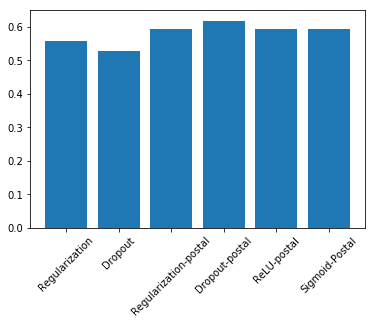

In [177]:
# plotting RMSE score for all regression models

score_list_reg=[score_regularization,score_dropout,score_regularization_ad,score_dropout_ad,score_relu_postal ,score_sigmoid_postal ]
names =['Regularization','Dropout', 'Regularization-postal','Dropout-postal','ReLU-postal','Sigmoid-Postal']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg)), score_list_reg)
plt.xticks(tick_marks, names, rotation=45)
plt.show()